In [211]:
%matplotlib inline

In [212]:
import pickle
import psf_toolkit as tk
import matplotlib.pyplot as plt
import numpy as np

In [213]:
#Lambda_RCA_path = '/Users/mschmitz/GitHub/LambdaRCA/'
Lambda_RCA_path = '/Users/rararipe/Documents/LambdaRCA-master/'

# Explore inputs

In [108]:
[output_stack,dec_stack,sig,flux,spectrums,field_pos] = pickle.load(open( Lambda_RCA_path+"Data/sim_starsx100_10dB.sav", "rb" ) )

print output_stack.shape # (21, 21, 100)        LR pixel x LR pixel x nobj number of objects -   inputs?
print dec_stack.shape    # (42, 42, 100, 100)   HR pixel x HR pixel x wavelength for each object? x nobj      -   ground truth?
print sig.shape          # (100, 1)             Noise estimation
print flux.shape         # (100,)               ... flux. 
print spectrums.shape    # (100, 100)           SED 100 objects, 100 lambdas each
print field_pos.shape    # (100, 2)             FOV positions of the 100 objects

(21, 21, 100)
(42, 42, 100, 100)
(100, 1)
(100,)
(100, 100)
(100, 2)


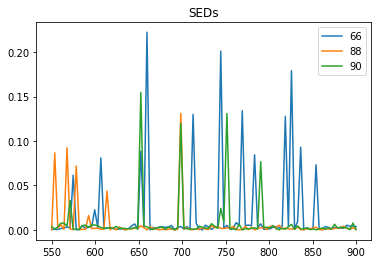

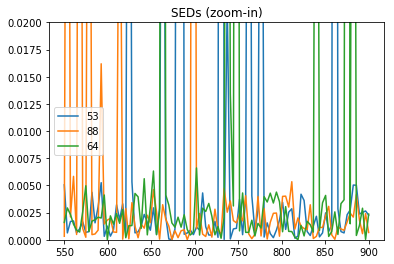

In [109]:
lbdas = np.linspace(550,900,100) # VIS 
    
for sed_idx in np.random.choice(100,3,False):
    plt.plot(lbdas, spectrums[sed_idx,:], label='{}'.format(sed_idx))
plt.legend()
plt.title('SEDs')
plt.show()
plt.close()

lbdas = np.linspace(550,900,100) # VIS
    
for sed_idx in np.random.choice(100,3,False):
    plt.plot(lbdas, spectrums[sed_idx,:], label='{}'.format(sed_idx))
plt.legend()
plt.ylim(0,0.02)
plt.title('SEDs (zoom-in)')
plt.show()
plt.close()

# optim_utils.py

In [214]:
import gc
import numpy.linalg as LA
from numpy import *
import numpy as np
import scipy.sparse.linalg as SLA
from multiprocessing import Process, Queue, Pool
import numpy.random as random
import scipy.signal as scisig
import isap
import sys
sys.path.append('../utilities')
import utils
import os
import scipy.stats as scistats
import copy as cp
from pyflann import *
#import psf_learning_utils
import scipy
from scipy.optimize import minimize#,linear_sum_assignment
sys.path.append('../sams')
#import cost as sams_cost
#import gradient as sams_grad
#import linear as sams_linear
#import proximity as sams_prox
#import optimisation as sams_optim

try:
    import pyct
except ImportError, e:
    pass # module doesn't exist, deal with it.

# utils.py

In [215]:
import subprocess
import os
import random
import cv2
from numpy import zeros,size,where,ones,copy,around,double,sinc,random,pi,arange,cos,sin,arccos,transpose,diag,sqrt,arange,floor,exp,array,mean,roots,float64,int,pi,median,rot90,argsort,tile,repeat,squeeze
from numpy.linalg import svd,norm,inv,eigh
import numpy.ma as npma
from numpy.random import randn,choice
import scipy.ndimage
import scipy
import scipy.signal as scisig
import scipy.ndimage.interpolation as ndii
import scipy.fftpack as scipy_fft
from pyflann import *
from multiprocessing import Process, Queue
from astropy.io import fits
import sys
sys.path.append('../utilities')
import gaussfitter
#import great3_util
#import optim_utils
#import isap
from scipy.spatial import ConvexHull
import scipy.fftpack as fftp
#from astropy.modeling import models#, fitting
import warnings
from scipy.ndimage.interpolation import zoom
import scipy.stats as scistats
import pywt
import copy as cp
from matplotlib import pyplot as plt,animation
import datetime,time

from scipy import interpolate

import scipy.linalg as sci_lin

In [216]:
def diagonally_dominated_mat(shap,sig=4.,thresh_en=True,coord_map=None,pol_en=False,pol_mod=False,theta_param=1,cent=None):
    from optim_utils import dist_map_2
    from numpy import sqrt as numsqrt
    coord_cloud = None
    if coord_map is None:
        coord_map = zeros((shap[0],shap[1],2))
        coord_map[:,:,0] = arange(0,shap[0]).reshape((shap[0],1)).dot(ones((1,shap[1])))
        coord_map[:,:,1] = ones((shap[0],1)).dot(arange(0,shap[1]).reshape((1,shap[1])))
        coord_cloud = zeros((2,shap[0]*shap[1]))
        coord_cloud[0,:] = coord_map[:,:,0].reshape((shap[0]*shap[1],))
        coord_cloud[1,:] = coord_map[:,:,1].reshape((shap[0]*shap[1],))
        if pol_en:
            if cent is None:
                cent = array([shap[0]/2,shap[1]/2])
            coord_cloud = polar_coord_cloud(coord_cloud,cent)
            coord_map[:,:,0] = cloud_out[0,:].reshape((shap[0],shap[1]))
            coord_map[:,:,1] = theta_param*cloud_out[1,:].reshape((shap[0],shap[1]))/(2*pi)
            if pol_mod:
                coord_map[:,:,1] *= coord_map[:,:,0]
                coord_cloud[1,:] *= coord_cloud[0,:]
    dist_map = sqrt(dist_map_2(coord_cloud))
    mat = exp(-dist_map**2/sig**2)
    if thresh_en:
        i,j = where(mat>exp(-1.))
        mat*=0
        mat[i,j] = 1.
    mat/=mat.sum()

    return mat

In [217]:
def diagonally_dominated_mat_stack(shap,nb_mat,sig=4.,thresh_en=True,coord_map=None,pol_en=False,\
    pol_mod=False,theta_param=1,cent=None):
    mat_ref = diagonally_dominated_mat(shap,sig=sig,thresh_en=thresh_en,coord_map=coord_map,\
    pol_en=pol_en,pol_mod=pol_mod,theta_param=theta_param,cent=cent)
    mat = zeros((shap[0]*shap[1],shap[0]*shap[1],nb_mat))
    for i in range(0,nb_mat):
        mat[:,:,i] = copy(mat_ref)
    return mat

In [218]:
def polar_coord_cloud(coord,cent):
    from numpy import zeros
    shap = coord.shape
    out = zeros((2,shap[1]))

    for i in range(0,shap[1]):
        out[0,i],out[1,i] = polar_coord(coord[:,i],cent)

    return out

In [219]:
def polar_coord(coord,cent): # Angle in radians
    from numpy import sqrt,arccos,abs,pi
    r = sqrt((coord[0]-cent[0])**2+(coord[1]-cent[1])**2)
    alpha=None
    if r==0:
        alpha=0
    else:
        alpha_ref = arccos(abs(coord[0]-cent[0])/r)
        alpha = alpha_ref
        if (coord[0]-cent[0]<0) and (coord[1]-cent[1]>=0):
            alpha = pi-alpha
        elif (coord[0]-cent[0]<0) and (coord[1]-cent[1]<0):
            alpha = pi+alpha
        elif (coord[0]-cent[0]>=0) and (coord[1]-cent[1]<0):
            alpha = 2*pi-alpha

    return r,alpha

In [220]:
def im_gauss_nois_est_cube(cube,opt=None,filters=None,return_map=False):
    shap = cube.shape
    sig = zeros((shap[2],))
    map = None
    if return_map:
        map =ones(shap)

    for i in range(0,shap[2]):
        sig_i,filters = im_gauss_nois_est(cube[:,:,i],opt=opt,filters=filters)
        sig[i] = sig_i
        if return_map:
            map[:,:,i] *= sig[i]
    if return_map:
        return sig,filters,return_map
    else:
        return sig,filters

In [221]:
def im_gauss_nois_est(im,opt=['-t2','-n2'],filters=None):
    #from isap import mr_trans_2
    Result,filters = mr_trans_2(im,filters=filters,opt=opt) ##from isap
    siz = im.shape
    norm_wav = norm(filters[:,:,0])
    sigma = 1.4826*mad(Result[:,:,0])/norm_wav

    return sigma,filters

In [222]:
def rand_file_name(ext):
    current_time = datetime.datetime.now().time()
    return 'file'+str(time.clock())+ext

In [223]:
def mad(x):
    import numpy
    return median(abs(x-median(x)))

In [224]:
def thresholding_3D(x,thresh,thresh_type):
    from numpy import copy
    shap = x.shape
    nb_plan = shap[2]
    k=0
    xthresh = copy(x)
    for k in range(0,nb_plan):
        xthresh[:,:,k] = thresholding(copy(x[:,:,k]),thresh[:,:,k],thresh_type)

    return xthresh

In [225]:
def thresholding(x,thresh,thresh_type): # x is a 1D or 2D array, thresh is an array of the same size, thresh_type is 1 or 0, 1 for soft thresholding, 0 for hard thresholding
    xthresh = copy(x)
    n = x.shape

    if len(n)>0:
        n1 = n[0]
    else:
        n1=1
    n2=1
    if len(n)==2:n2 =n[1]
    i,j = 0,0
    if len(n)==2:
        for i in range(0,n1):
            for j in range(0,n2):
                if abs(xthresh[i,j])<thresh[i,j]:xthresh[i,j]=0
                else:
                    if xthresh[i,j]!=0:xthresh[i,j]=(abs(xthresh[i,j])/xthresh[i,j])*(abs(xthresh[i,j])-thresh_type*thresh[i,j])

    elif len(n)==1:
        for i in range(0,n1):
            if abs(xthresh[i])<thresh[i]:xthresh[i]=0
            else:
                if xthresh[i]!=0:xthresh[i]=(abs(xthresh[i])/xthresh[i])*(abs(xthresh[i])-thresh_type*thresh[i])
    elif len(n)==0:
        if abs(xthresh)<thresh:xthresh=0
        else:
            if xthresh!=0:xthresh=(abs(xthresh)/xthresh)*(abs(xthresh)-thresh_type*thresh)

    return xthresh

In [226]:
def shift_est(psf_stack): #
    shap = psf_stack.shape
    U = zeros((shap[2],2))
    param=gaussfitter.gaussfit(psf_stack[:,:,0],returnfitimage=False)
    #(centroid_ref,Wc) = compute_centroid(psf_stack[:,:,0],(param[3]+param[4])/2)
    centroid_out = zeros((shap[2],2))
    for i in range(0,shap[2]):
        param=gaussfitter.gaussfit(psf_stack[:,:,i],returnfitimage=False)
        #(centroid,Wc) = compute_centroid(psf_stack[:,:,i],(param[3]+param[4])/2)
        (centroid,Wc) = compute_centroid(psf_stack[:,:,i],(param[3]+param[4])/2)
        U[i,0] = centroid[0,0]-double(shap[0])/2
        U[i,1] = centroid[0,1]-double(shap[1])/2
        centroid_out[i,0]  = centroid[0,0]
        centroid_out[i,1]  = centroid[0,1]
    return U,centroid_out

In [227]:
def compute_centroid(im,sigw=None,nb_iter=4):
    if sigw is None:
        param=gaussfitter.gaussfit(im,returnfitimage=False)
        #print param
        sigw = (param[3]+param[4])/2
    sigw = float(sigw)
    n1 = im.shape[0]
    n2 = im.shape[1]
    rx = array(range(0,n1))
    ry = array(range(0,n2))
    Wc = ones((n1,n2))
    centroid = zeros((1,2))
    # Four iteration loop to compute the centroid
    i=0
    for i in range(0,nb_iter):

        xx = npma.outerproduct(rx-centroid[0,0],ones(n2))
        yy = npma.outerproduct(ones(n1),ry-centroid[0,1])
        W = npma.exp(-(xx**2+yy**2)/(2*sigw**2))
        centroid = zeros((1,2))
        # Estimate Centroid
        Wc = copy(W)
        if i == 0:Wc = ones((n1,n2))
        totx=0.0
        toty=0.0
        cx=0
        cy=0

        for cx in range(0,n1):
            centroid[0,0] += (im[cx,:]*Wc[cx,:]).sum()*(cx)
            totx += (im[cx,:]*Wc[cx,:]).sum()
        for cy in range(0,n2):
            centroid[0,1] += (im[:,cy]*Wc[:,cy]).sum()*(cy)
            toty += (im[:,cy]*Wc[:,cy]).sum()
        centroid = centroid*array([1/totx,1/toty])


    return (centroid,Wc)

In [228]:
def shift_ker_stack(shifts,upfact,lanc_rad=4):
    from numpy import rot90
    shap = shifts.shape
    shift_ker_stack = zeros((2*lanc_rad+1,2*lanc_rad+1,shap[0]))
    shift_ker_stack_adj = zeros((2*lanc_rad+1,2*lanc_rad+1,shap[0]))

    for i in range(0,shap[0]):

        uin = shifts[i,:].reshape((1,2))*upfact
        shift_ker_stack[:,:,i] = lanczos(uin,n=lanc_rad)
        shift_ker_stack_adj[:,:,i] = rot90(shift_ker_stack[:,:,i],2)

    return shift_ker_stack,shift_ker_stack_adj

In [229]:
def lanczos(U,n=10,n2=None):
    if n2 is None:
        n2 = n
    siz = size(U)
    H = None
    if (siz == 2):
        U_in = copy(U)
        if len(U.shape)==1:
            U_in = zeros((1,2))
            U_in[0,0]=U[0]
            U_in[0,1]=U[1]
        H = zeros((2*n+1,2*n2+1))
        if (U_in[0,0] == 0) and (U_in[0,1] == 0):
            H[n,n2] = 1
        else:
            i=0
            j=0
            for i in range(0,2*n+1):
                for j in range(0,2*n2+1):
                    H[i,j] = sinc(U_in[0,0]-(i-n))*sinc((U_in[0,0]-(i-n))/n)*sinc(U_in[0,1]-(j-n))*sinc((U_in[0,1]-(j-n))/n)

    else :
        H = zeros((2*n+1,))
        for i in range(0,2*n):
            H[i] = sinc(pi*(U-(i-n)))*sinc(pi*(U-(i-n))/n)
    return H

In [230]:
def flux_estimate_stack(stack,cent=None,rad=4):
    shap = stack.shape
    flux = zeros((shap[2],))
    for i in range(0,shap[2]):
        if cent is not None:
            flux[i] = flux_estimate(stack[:,:,i],cent=cent[i,:],rad=rad)
        else:
            flux[i] = flux_estimate(stack[:,:,i],rad=rad)
    return flux

In [231]:
def flux_estimate(im,cent=None,rad=4): # Default value for the flux tunned for Euclid PSF at Euclid resolution
    flux = 0
    if cent is None:
        cent = array(where(im==im.max())).reshape((1,2))
    shap = im.shape
    for i in range(0,shap[0]):
        for j in range(0,shap[1]):
            if sqrt((i-cent[0,0])**2+(j-cent[0,1])**2)<=rad:
                flux = flux+im[i,j]
    return flux

In [232]:
def analysis(cube,sig,field_dist,p_min = 0.01,e_min=0.01,e_max=1.99,nb_max=30,tol=0.01): #not used because graph_cons_en=False here
    nb_samp_opt = 10
    shap = cube.shape
    nb_neighs = shap[2]-1
    neigh,dists = utils.knn_interf(field_dist,nb_neighs)
    p_max = pow_law_select(dists,nb_neighs)
    print "power max = ",p_max

    print "Done..."
    dists_unsorted = utils.feat_dist_mat(field_dist)
    e_range = utils.log_sampling(e_min,e_max,nb_samp_opt)
    p_range = utils.log_sampling(p_min,p_max,nb_samp_opt)
    res_mat = copy(transpose(cube.reshape((shap[0]*shap[1],shap[2]))))

    list_comp = list()
    list_e = list()
    list_p = list()
    list_ind = list()
    list_ker = list()
    err = 1e20
    nb_iter = 0
    while nb_iter<nb_max: # err>sig and
        expo_out,e_out,loss,vect,ker,j = notch_filt_optim_2(res_mat,dists_unsorted,p_range,e_range,nb_iter=3,tol=tol)
        list_e.append(e_out)
        list_p.append(expo_out)
        list_comp.append(vect)
        list_ind.append(j)
        list_ker.append(ker)
        nb_iter+=1
        res_mat = res_mat-transpose(vect).dot(vect.dot(res_mat))
        print "nb_comp: ",nb_iter," residual: ",loss," e: ",e_out," p: ",expo_out,"chosen index: ",j,"/",shap[2]
        err = sum(res_mat**2)

    e_vect = zeros((nb_iter,))
    p_vect = zeros((nb_iter,))
    weights = zeros((nb_iter,shap[2]))
    ker = zeros((nb_iter*shap[2],shap[2]))
    ind = zeros((nb_iter,nb_iter*shap[2]))
    for i in range(0,nb_iter):
        e_vect[i] = list_e[i]
        p_vect[i] = list_p[i]
        weights[i,:] = list_comp[i].reshape((shap[2],))
        ker[i*shap[2]:(i+1)*shap[2],:] = list_ker[i]
        ind[i,i*shap[2]+list_ind[i]] = 1


    res_mat = copy(transpose(cube.reshape((shap[0]*shap[1],shap[2]))))
    proj_coeff = weights.dot(res_mat)
    comp = utils.mat_to_cube(proj_coeff,shap[0],shap[1])

    proj_data = transpose(weights).dot(proj_coeff)
    proj_data = utils.mat_to_cube(proj_data,shap[0],shap[1])

    return e_vect,p_vect,weights,comp,proj_data,ker,ind

In [233]:
def cube_svd(cube,nb_comp=None,ind=None,mean_sub=False):
    shap = cube.shape
    if nb_comp is None:
        nb_comp = min(shap[0]*shap[1],shap[2])
    mat = cube.reshape((shap[0]*shap[1],shap[2]))
    data_mean = None
    centered_data = None
    if ind is None:
        ind = range(0,shap[2])
    if mean_sub:
        data_mean = cube.mean(axis=2)
        mat -= data_mean.reshape((shap[0]*shap[1],1)).dot(ones((1,shap[2])))
        centered_data = copy(cube)
        for i in range(0,shap[2]):
            centered_data[:,:,i]-=data_mean
    U, s, Vt = svd(mat[:,ind],full_matrices=False)
    shap_u = U.shape
    coeff = transpose(U[:,0:nb_comp]).dot(mat)
    approx = U[:,0:nb_comp].dot(coeff)
    comp_cube = U[:,0:nb_comp].reshape((shap[0],shap[1],min(nb_comp,shap[2])))
    approx_cube =  approx.reshape((shap[0],shap[1],shap[2]))
    if mean_sub:
        return coeff,comp_cube,approx_cube,data_mean,centered_data
    else:
        return coeff,comp_cube,approx_cube

In [234]:
def get_noise_arr(arr):

    shap = arr.shape
    ind = list()
    for i in shap[2:]:
        ind.append(arange(0,i))
    coord = cartesian_product(ind)
    noise_map = ones(arr.shape)
    s = slice(None) # equivalent to ':
    for i in range(0,coord.shape[0]):
        sig = get_noise(arr[(s,s)+tuple(coord[i,:])])
        noise_map[(s,s)+tuple(coord[i,:])]*=sig

    return noise_map

In [235]:
def cartesian_product(arrays):
    import numpy as numpy
    broadcastable = numpy.ix_(*arrays)
    broadcasted = numpy.broadcast_arrays(*broadcastable)
    rows, cols = reduce(numpy.multiply, broadcasted[0].shape), len(broadcasted)
    out = numpy.empty(rows * cols, dtype=broadcasted[0].dtype)
    start, end = 0, rows
    for a in broadcasted:
        out[start:end] = a.reshape(-1)
        start, end = end, end + rows
    return out.reshape(cols, rows).T

In [236]:
def get_noise(im,nb_iter=5,k=3):
    sig = 1.4826*mad(im)
    for i in range(0,nb_iter):
        im_thresh = im*(abs(im)>k*sig)
        sig = 1.4826*mad(im-im_thresh)
    return sig

# isap.py

In [237]:
import subprocess
import os
from astropy.io import fits
import sys
sys.path.append('../utilities')
#import utils
from numpy import *
import scipy.signal as scisig
try:
    import pyct
except ImportError, e:
    pass # module doesn't exist, deal with it.
import numpy

In [238]:
def mr_trans_2(im,filters=None,opt=None,exe_path=''):
    shap = im.shape
    if filters is None:
        dirac = zeros((shap[0]-(shap[0]-1)%2,shap[1]-(shap[1]-1)%2)) # Odd dimensions needed
        dirac[int((shap[0]-(shap[0]-1)%2-1)/2),int((shap[1]-(shap[1]-1)%2-1)/2)] = 1
        filters,file = mr_trans(dirac,opt=opt,exe_path=exe_path)
        os.remove(file)
    shap_wav = filters.shape
    output = zeros((shap[0],shap[1],shap_wav[2]))

    for i in range(0,shap_wav[2]):
        temp = scisig.fftconvolve(im,filters[:,:,i],mode='same')
        output[:,:,i]  =temp
    return output,filters

In [239]:
def mr_trans(im,opt=None,path='',exe_path=''):
    NameImag = path+utils.rand_file_name('.fits') ##from utils
    NameResult = path+utils.rand_file_name('')
    # Writes the input image to a fits file
    fits.writeto(NameImag,im)
    # Performing the system call
    mr_exe = exe_path+'mr_transform'
    if opt is None:
        subprocess.call([mr_exe, NameImag, NameResult])
    else:
        subprocess.call([mr_exe]+opt+[NameImag, NameResult])
    Result = fits.getdata(NameResult+'.mr')

    os.remove(NameImag)
    return swapaxes(swapaxes(Result,0,1),1,2),NameResult+'.mr'

# psf_learning_utils.py

In [240]:
import gc
#import utils
#import optim_utils
from numpy import *
import numpy as np
from scipy.interpolate import Rbf
from scipy.fftpack import dct,idct
import scipy.signal as scisig
#from utils import bar_coord2d
import sys
sys.path.append('../../Github/python_lib/python/psf')
sys.path.append('../utilities')
#import isap
from numpy.random import randn

In [241]:
def full_displacement(shap,supp,t,pol_en=False,cent=None,theta_param=1,pol_mod=False,coord_map=None,knn=None,eps = 1.e-16):
    from numpy import ones,zeros,copy,array,pi,int,transpose,diag
    #from utils import polar_coord_cloud
    from pyflann import FLANN
    
    ## parameters:
#     shap = shap
#     supp = supp,
#     t = t
#     pol_en=True
#     cent=None
#     theta_param=1
#     pol_mod=True
#     coord_map=None
#     knn=None
#     eps = 1.e-16
    
    if coord_map is None:
        coord_map = zeros((shap[0],shap[1],2))
        coord_map[:,:,0] = arange(0,shap[0]).reshape((shap[0],1)).dot(ones((1,shap[1])))
        coord_map[:,:,1] = ones((shap[0],1)).dot(arange(0,shap[1]).reshape((1,shap[1])))
        if pol_en:
            if cent is None:
                cent = array([shap[0]/2,shap[1]/2])
            cloud_in = zeros((2,shap[0]*shap[1]))
            cloud_in[0,:] = copy(coord_map[:,:,0].reshape((shap[0]*shap[1],)))
            cloud_in[1,:] = copy(coord_map[:,:,1].reshape((shap[0]*shap[1],)))
            cloud_out = polar_coord_cloud(cloud_in,cent)
            coord_map[:,:,0] = cloud_out[0,:].reshape((shap[0],shap[1]))
            coord_map[:,:,1] = theta_param*cloud_out[1,:].reshape((shap[0],shap[1]))/(2*pi)
            if pol_mod:
                coord_map[:,:,1] *= coord_map[:,:,0]
        knn = FLANN()
        cloud_in = zeros((shap[0]*shap[1],2))
        cloud_in[:,0] = copy(coord_map[:,:,0].reshape((shap[0]*shap[1],)))
        cloud_in[:,1] = copy(coord_map[:,:,1].reshape((shap[0]*shap[1],)))
        params = knn.build_index(array(cloud_in, dtype=float64))

    advection_points = zeros((supp.shape[0],2,size(t)))

    for i in range(0,supp.shape[0]):
        # Matching coordinates
        pos1_i = int(supp[i,0]/(shap[0]))
        pos1_j = int(supp[i,0]%(shap[0]))
        pos2_i = int(supp[i,1]/(shap[0]))
        pos2_j = int(supp[i,1]%(shap[0]))

        if size(t)==1:
            advection_points[i,0,0] = (1-t)*coord_map[pos1_i,pos1_j,0]+t*coord_map[pos2_i,pos2_j,0]
            advection_points[i,1,0] = (1-t)*coord_map[pos1_i,pos1_j,1]+t*coord_map[pos2_i,pos2_j,1]
        else:
            for j in range(0,size(t)):
                advection_points[i,0,j] = (1-t[j])*coord_map[pos1_i,pos1_j,0]+t[j]*coord_map[pos2_i,pos2_j,0]
                advection_points[i,1,j] = (1-t[j])*coord_map[pos1_i,pos1_j,1]+t[j]*coord_map[pos2_i,pos2_j,1]

    neighbors_graph = zeros((supp.shape[0],4,size(t)))
    neighbors_graph = zeros((supp.shape[0],2,4,size(t)))
    weights_neighbors = zeros((supp.shape[0],4,size(t)))

    if size(t)==1:
        neighbors_graph_temp,dist_neighbors = knn.nn_index(advection_points[:,:,0],4)
        neighbors_graph[:,0,:,0] = neighbors_graph_temp/shap[0]
        neighbors_graph[:,1,:,0] = neighbors_graph_temp%shap[0]
        inv_dist = (dist_neighbors+eps)**(-1)
        weights_neighbors[:,:,0] = inv_dist/(inv_dist.sum(axis=1).reshape((supp.shape[0],1)).dot(ones((1,4))))
    else:
        for j in range(0,size(t)):
            print "Wavelenght ",j+1,"/",size(t)
            neighbors_graph_temp,dist_neighbors = knn.nn_index(advection_points[:,:,j],4)
            neighbors_graph[:,0,:,j] = neighbors_graph_temp/shap[0]
            neighbors_graph[:,1,:,j] = neighbors_graph_temp%shap[0]
            inv_dist = (dist_neighbors+eps)**(-1)
            weights_neighbors[:,:,j] = inv_dist/(inv_dist.sum(axis=1).reshape((supp.shape[0],1)).dot(ones((1,4))))
    gc.collect()

    return neighbors_graph.astype(int),weights_neighbors,cent,coord_map,knn

In [242]:
def transport_plan_projections_field(P_stack,shap,supp,neighbors_graph,weights_neighbors,spectrums,A,flux,sig,ker,D):

    from numpy import zeros,ones,prod,median
    nb_comp = P_stack.shape[-1]
    nb_bands = spectrums.shape[0]
    nb_im = size(flux)
    multi_spec_comp_mat = zeros((shap[0]*shap[1],nb_comp,nb_bands))
    mono_chromatic_psf = zeros((shap[0]*shap[1],nb_im,nb_bands))
    ones_vect = ones((nb_bands,))

    for i in range(0,nb_comp):
        multi_spec_comp = transport_plan_projections(P_stack[:,:,i],shap,supp,neighbors_graph,weights_neighbors)
        multi_spec_comp_mat[:,i,:] = multi_spec_comp.reshape((prod(shap),nb_bands))

    for i in range(0,nb_bands):
        mono_chromatic_psf[:,:,i] = multi_spec_comp_mat[:,:,i].dot(A)

    stars_est = zeros((shap[0]/D,shap[1]/D,nb_im))
    for i in range(0,nb_im):
        stars_temp = (mono_chromatic_psf[:,i,:].dot(spectrums[:,i].reshape((nb_bands,1)))).reshape(shap)
        stars_est[:,:,i] = (flux[i]/sig[i])*utils.decim(scisig.fftconvolve(stars_temp,ker[:,:,i],mode='same'),D,av_en=0)
    gc.collect()

    return stars_est

In [243]:
def transport_plan_projections(P,shap,supp,neighbors_graph,weights_neighbors,spectrum=None,indices=None):
    from numpy import zeros,int,squeeze,add,ones

    if indices is None:
        nb_proj = neighbors_graph.shape[3]
        indices = arange(0,nb_proj)
    else:
        nb_proj = size(indices)
    if spectrum is None:
        spectrum = ones((nb_proj,))
    im_proj = zeros((shap[0],shap[1],nb_proj))
    siz_supp = neighbors_graph.shape[0]
    for i in range(0,nb_proj):
        add.at(im_proj[:,:,indices[i]],(neighbors_graph[:,0,:,indices[i]],neighbors_graph[:,1,:,indices[i]]),\
        spectrum[indices[i]]*weights_neighbors[:,:,indices[i]]*P[supp[:,0],supp[:,1]].reshape((siz_supp,1)).dot(ones((1,4))))

    return squeeze(im_proj)

In [244]:
def transport_plan_projections_field_transpose(im_stack,supp,neighbors_graph,weights_neighbors,spectrums,A,flux,sig,ker_rot,D):

    from numpy import zeros,ones,prod,median,diag
    nb_comp = A.shape[0]
    nb_bands = spectrums.shape[0]
    nb_im = size(flux)
    shap_lr = im_stack.shape
    shap = (shap_lr[0]*D,shap_lr[1]*D)
    psf_est = zeros((shap[0]*shap[1],nb_im))
    for i in range(0,nb_im):
        psf_temp = (flux[i]/sig[i])*scisig.convolve(utils.transpose_decim(im_stack[:,:,i],D),ker_rot[:,:,i],mode='same')
        psf_est[:,i] = psf_temp.reshape((prod(shap),))
    comp_est = zeros((shap[0]*shap[1],nb_comp,nb_bands))
    for i in range(0,nb_bands):
        comp_est[:,:,i] = psf_est.dot(diag(spectrums[i,:]).dot(transpose(A)))
    ones_vect = ones((nb_bands,))
    P_stack = zeros((prod(shap),prod(shap),nb_comp))
    for i in range(0,nb_comp):
        P_stack[:,:,i] = transport_plan_projections_transpose_2(comp_est[:,i,:].reshape((shap[0],shap[1],nb_bands)),supp,neighbors_graph,weights_neighbors,ones_vect).sum(axis=2)
    gc.collect()
    return P_stack

In [245]:
def transport_plan_projections_transpose_2(im_stack,supp,neighbors_graph,weights_neighbors,spectrum):
    from numpy import zeros,squeeze,sqrt,add,repeat
    shap = im_stack.shape
    nb_proj = neighbors_graph.shape[3]
    P_out = zeros((shap[0]*shap[1],shap[0]*shap[1],nb_proj))
    siz_supp = neighbors_graph.shape[0]
    indx = repeat(supp[:,0],4).reshape((siz_supp,4))
    indy = repeat(supp[:,1],4).reshape((siz_supp,4))

    for i in range(0,nb_proj):
        add.at(P_out[:,:,i],(indx,indy),spectrum[i]*weights_neighbors[:,:,i]*im_stack[neighbors_graph[:,0,:,i],neighbors_graph[:,1,:,i],i])
    return P_out

In [246]:
def transport_plan_projections_field_coeff_transpose(im_stack,supp,neighbors_graph,weights_neighbors,spectrums,P_stack,flux,sig,ker_rot,D):

    from numpy import zeros,ones,prod,median,diag

    nb_comp = P_stack.shape[2]
    nb_bands = spectrums.shape[0]
    nb_im = size(flux)
    shap_lr = im_stack.shape
    shap = (shap_lr[0]*D,shap_lr[1]*D)
    multi_spec_comp_mat = zeros((shap[0]*shap[1],nb_comp,nb_bands))
    psf_est = zeros((shap[0]*shap[1],nb_im))
    for i in range(0,nb_im):
        psf_temp = (flux[i]/sig[i])*scisig.convolve(utils.transpose_decim(im_stack[:,:,i],D),ker_rot[:,:,i],mode='same')
        psf_est[:,i] = psf_temp.reshape((prod(shap),))

    ones_vect = ones((nb_bands,))
    for i in range(0,nb_comp):
        multi_spec_comp = transport_plan_projections(P_stack[:,:,i],shap,supp,neighbors_graph,weights_neighbors)
        multi_spec_comp_mat[:,i,:] = multi_spec_comp.reshape((prod(shap),nb_bands))

    A = zeros((nb_comp,nb_im))
    for i in range(0,nb_im):
        Si = zeros((shap[0]*shap[1],nb_comp))
        for k in range(0,nb_comp):
            Si[:,k] = (multi_spec_comp_mat[:,k,:].dot(spectrums[:,i].reshape((nb_bands,1)))).reshape((prod(shap),))
        A[:,i] = (transpose(Si).dot(psf_est[:,i].reshape((prod(shap),1)))).reshape((nb_comp,))
    gc.collect()

    return A

In [247]:
def transport_plan_projections_flat_field(P_stack,supp,A):
    return P_stack[supp[:,0],supp[:,1],:].dot(A)

In [248]:
def transport_plan_projections_field_marg(P_stack,shap,supp,neighbors_graph,weights_neighbors):
    nb_plans = P_stack.shape[-1]
    output = zeros((shap[0],shap[1],nb_plans))
    for i in range(0,nb_plans):
        output[:,:,i] = transport_plan_projections(P_stack[:,:,i],shap,supp,neighbors_graph,weights_neighbors,indices=[0])

    return output


In [249]:
def columns_wise_simplex_proj(mat,mass=None):

    from simplex_projection import euclidean_proj_simplex
    nb_columns = mat.shape[1]
    mat_out = zeros(mat.shape)
    if mass is None:
        mass = max(0,((mat*(mat>=0)).sum(axis=0)).mean())
    if mass>0:
        for i in range(0,nb_columns):
            mat_out[:,i] = euclidean_proj_simplex(mat[:,i],s=mass)

    return mat_out

In [250]:
def transport_plan_projections_flat_field_transpose(P_mat,supp,A,shap):
    temp_mat = P_mat.dot(transpose(A))
    P_stack = zeros((prod(shap),prod(shap),A.shape[0]))
    P_stack[supp[:,0],supp[:,1],:] = temp_mat
    return P_stack

In [251]:
def transport_plan_projections_field_marg_transpose(im_stack,shap,supp,neighbors_graph,weights_neighbors):
    nb_plans = im_stack.shape[-1]
    output = zeros((shap[0]*shap[1],shap[0]*shap[1],nb_plans))
    for i in range(0,nb_plans):
        output[:,:,i] = transport_plan_projections_transpose(im_stack[:,:,i],supp,neighbors_graph,weights_neighbors,indices=[0])
    return output

In [252]:
def transport_plan_projections_transpose(im,supp,neighbors_graph,weights_neighbors,spectrum=None,indices=None):
    from numpy import zeros,squeeze,sqrt,add,repeat

    shap = im.shape
    if indices is None:
        nb_proj = neighbors_graph.shape[3]
        indices = arange(0,nb_proj)
    else:
        nb_proj = size(indices)
    if spectrum is None:
        spectrum = ones((nb_proj,))
    P_out = zeros((shap[0]*shap[1],shap[0]*shap[1],nb_proj))
    siz_supp = neighbors_graph.shape[0]
    indx = repeat(supp[:,0],4).reshape((siz_supp,4))
    indy = repeat(supp[:,1],4).reshape((siz_supp,4))

    for i in range(0,nb_proj):
        add.at(P_out[:,:,indices[i]],(indx,indy),spectrum[indices[i]]*weights_neighbors[:,:,indices[i]]\
                                *im[neighbors_graph[:,0,:,indices[i]],neighbors_graph[:,1,:,indices[i]]])
    return squeeze(P_out)

In [319]:
def field_reconstruction(P_stack,shap,supp,neighbors_graph,weights_neighbors,A):

        from numpy import zeros,ones,prod,median
        nb_comp = P_stack.shape[-1]
        nb_bands = neighbors_graph.shape[-1]
        nb_im = A.shape[1]
        multi_spec_comp_mat = zeros((shap[0]*shap[1],nb_comp,nb_bands))
        mono_chromatic_psf = zeros((shap[0],shap[1],nb_im,nb_bands))
        ones_vect = ones((nb_bands,))

        for i in range(0,nb_comp):
            multi_spec_comp = transport_plan_projections(P_stack[:,:,i],shap,supp,neighbors_graph,weights_neighbors)
            multi_spec_comp_mat[:,i,:] = multi_spec_comp.reshape((prod(shap),nb_bands))

        for i in range(0,nb_bands):
            mono_chromatic_psf_temp = multi_spec_comp_mat[:,:,i].dot(A)
            for j in range(0,nb_im):
                mono_chromatic_psf[:,:,j,i] = mono_chromatic_psf_temp[:,j].reshape((shap[0],shap[1]))

        return mono_chromatic_psf

In [320]:
def transport_plan_projections_flat_field_transpose_coeff(P_mat,P_stack,supp):
    return transpose(P_stack[supp[:,0],supp[:,1],:]).dot(P_mat)

# gradient.py

In [255]:
import sys
#sys.path.append('../utilities')
import numpy as np
#from algorithms import PowerMethod
#from convolve import psf_convolve
#from psf_learning_utils import transport_plan_projections_field,transport_plan_projections_field_transpose,\
#                                transport_plan_projections_field_coeff_transpose 

In [298]:
class polychrom_eigen_psf(GradBasic, PowerMethod):
    """Polychromatic eigen PSFs class

    This class defines the operators for a field of undersampled space varying
    polychromatic PSFs. These operators are related to the eigen PSFs estimation.

    Parameters
    ----------
    data : np.ndarray
        Input data array, a array of 2D observed images (i.e. with noise)


    Notes
    -----
    The properties of `GradBasic` and `PowerMethod` are inherited in this class

    """

    def __init__(self, data, supp, neighbors_graph, weights_neighbors, spectrums, \
                A, flux, sig, ker, ker_rot, D):

        self.y = data
        shap = data.shape
        self.shape = (shap[0]*D,shap[1]*D)
        self.D = D
        self.supp = supp
        self.neighbors_graph = neighbors_graph
        self.weights_neighbors = weights_neighbors
        self.spectrums = spectrums
        self.A = np.copy(A)
        self.flux = flux
        self.sig = sig
        self.ker = ker
        self.ker_rot  = ker_rot
        PowerMethod.__init__(self, self.MtMX, (np.prod(self.shape),np.prod(self.shape),A.shape[0]))

    def set_A(self,A_new,pwr_en=True):
        self.A = np.copy(A_new)
        if pwr_en:
            PowerMethod.__init__(self, self.MtMX, (np.prod(self.shape),np.prod(self.shape),self.A.shape[0]))

    def set_flux(self,flux_new,pwr_en=False):
        self.flux = np.copy(flux_new)
        if pwr_en:
            PowerMethod.__init__(self, self.MtMX, (np.prod(self.shape),np.prod(self.shape),self.A.shape[0]))

    def get_flux(self):
        return self.flux

    def MX(self, x):
        """MX

        This method calculates the action of the matrix M on the data X

        Parameters
        ----------
        x : np.ndarray
            Input data array, a cube of transportation plans

        Returns
        -------
        np.ndarray result

        """
        return transport_plan_projections_field(x,self.shape,self.supp,self.neighbors_graph\
                ,self.weights_neighbors,self.spectrums,self.A,self.flux,self.sig,self.ker,self.D)

    def MtX(self, x):
        """MtX

        This method calculates the action of the transpose of the matrix Mt on
        the data X

        Parameters
        ----------
        x : np.ndarray
            Input data array, a cube of 2D images

        Returns
        -------
        np.ndarray result

        """
        return transport_plan_projections_field_transpose(x,self.supp,self.neighbors_graph,\
                self.weights_neighbors,self.spectrums,self.A,self.flux,self.sig,self.ker_rot,self.D)

In [299]:
class GradBasic(object):
    """Basic gradient class

    This class defines the basic methods that will be inherited by specific
    gradient classes

    """

    def MtMX(self, x):
        """M^T M X

        This method calculates the action of the transpose of the matrix M on
        the action of the matrix M on the data X

        Parameters
        ----------
        x : np.ndarray
            Input data array

        Returns
        -------
        np.ndarray result

        Notes
        -----
        Calculates  M^T (MX)

        """

        return self.MtX(self.MX(x))

    def get_grad(self, x):
        """Get the gradient step

        This method calculates the gradient step from the input data

        Parameters
        ----------
        x : np.ndarray
            Input data array

        Returns
        -------
        np.ndarray gradient value

        Notes
        -----

        Calculates M^T (MX - Y)

        """

        self.grad = self.MtX(self.MX(x) - self.y)

In [300]:
class polychrom_eigen_psf_coeff_graph(GradBasic, PowerMethod):
    """Polychromatic eigen PSFs class

    This class defines the operators for a field of undersampled space varying
    polychromatic PSFs. These operators are related to the eigen PSFs weights estimation.

    Parameters
    ----------
    data : np.ndarray
        Input data array, a array of 2D observed images (i.e. with noise)


    Notes
    -----
    The properties of `GradBasic` and `PowerMethod` are inherited in this class

    """

    def __init__(self, data, supp, neighbors_graph, weights_neighbors, spectrums, \
                P, flux, sig, ker, ker_rot, D, basis):

        self.y = data
        shap = data.shape
        self.shape = (shap[0]*D,shap[1]*D)
        self.D = D
        self.supp = supp
        self.neighbors_graph = neighbors_graph
        self.weights_neighbors = weights_neighbors
        self.spectrums = spectrums
        self.P = np.copy(P)
        self.flux = flux
        self.sig = sig
        self.ker = ker
        self.ker_rot  = ker_rot
        self.basis = basis
        PowerMethod.__init__(self, self.MtMX, (P.shape[-1],self.basis.shape[0]))


    def set_P(self,P_new,pwr_en=True):
        self.P = np.copy(P_new)
        if pwr_en:
            PowerMethod.__init__(self, self.MtMX, (self.P.shape[-1],self.basis.shape[0]))

    def set_flux(self,flux_new,pwr_en=False):
        self.flux = np.copy(flux_new)
        if pwr_en:
            PowerMethod.__init__(self, self.MtMX, (self.P.shape[-1],self.basis.shape[0]))

    def get_flux(self):
        return self.flux


    def MX(self, x):
        """MX

        This method calculates the action of the matrix M on the data X

        Parameters
        ----------
        x : np.ndarray
            Input data array, a cube of transportation plans

        Returns
        -------
        np.ndarray result

        """
        return transport_plan_projections_field(self.P,self.shape,self.supp,self.neighbors_graph\
                ,self.weights_neighbors,self.spectrums,x.dot(self.basis),self.flux,self.sig,self.ker,self.D)

    def MtX(self, x):
        """MtX

        This method calculates the action of the transpose of the matrix Mt on
        the data X

        Parameters
        ----------
        x : np.ndarray
            Input data array, a cube of 2D images

        Returns
        -------
        np.ndarray result

        """
        return transport_plan_projections_field_coeff_transpose(x,self.supp,self.neighbors_graph,\
                self.weights_neighbors,self.spectrums,self.P,self.flux,self.sig,self.ker_rot,self.D).dot(np.transpose(self.basis))

In [301]:
class polychrom_eigen_psf_coeff(GradBasic, PowerMethod):
    """Polychromatic eigen PSFs class

    This class defines the operators for a field of undersampled space varying
    polychromatic PSFs. These operators are related to the eigen PSFs weights estimation.

    Parameters
    ----------
    data : np.ndarray
        Input data array, a array of 2D observed images (i.e. with noise)


    Notes
    -----
    The properties of `GradBasic` and `PowerMethod` are inherited in this class

    """

    def __init__(self, data, supp, neighbors_graph, weights_neighbors, spectrums, \
                P, flux, sig, ker, ker_rot, D):

        self.y = data
        shap = data.shape
        self.shape = (shap[0]*D,shap[1]*D)
        self.D = D
        self.supp = supp
        self.neighbors_graph = neighbors_graph
        self.weights_neighbors = weights_neighbors
        self.spectrums = spectrums
        self.P = np.copy(P)
        self.flux = flux
        self.sig = sig
        self.ker = ker
        self.ker_rot  = ker_rot
        PowerMethod.__init__(self, self.MtMX, (P.shape[-1],spectrums.shape[1]))


    def set_P(self,P_new,pwr_en=True):
        self.P = np.copy(P_new)
        if pwr_en:
            PowerMethod.__init__(self, self.MtMX, (self.P.shape[-1],self.spectrums.shape[1]))

    def set_flux(self,flux_new,pwr_en=False):
        self.flux = np.copy(flux_new)
        if pwr_en:
            PowerMethod.__init__(self, self.MtMX, (np.prod(self.shape),np.prod(self.shape),self.A.shape[0]))

    def get_flux(self):
        return self.flux

    def MX(self, x):
        """MX

        This method calculates the action of the matrix M on the data X

        Parameters
        ----------
        x : np.ndarray
            Input data array, a cube of transportation plans

        Returns
        -------
        np.ndarray result

        """
        return transport_plan_projections_field(self.P,self.shape,self.supp,self.neighbors_graph\
                ,self.weights_neighbors,self.spectrums,x,self.flux,self.sig,self.ker,self.D)

    def MtX(self, x):
        """MtX

        This method calculates the action of the transpose of the matrix Mt on
        the data X

        Parameters
        ----------
        x : np.ndarray
            Input data array, a cube of 2D images

        Returns
        -------
        np.ndarray result

        """
        return transport_plan_projections_field_coeff_transpose(x,self.supp,self.neighbors_graph,\
                self.weights_neighbors,self.spectrums,self.P,self.flux,self.sig,self.ker_rot,self.D)

# algorithms.py

In [260]:
import numpy as np
from scipy.linalg import norm

In [261]:
class PowerMethod(object):
    """Power method class

    This method performs implements power method to calculate the spectral
    radius of the input data

    Parameters
    ----------
    operator : class
        Operator class instance
    data_shape : tuple
        Shape of the data array
    auto_run : bool
        Option to automatically calcualte the spectral radius upon
        initialisation

    """

    def __init__(self, operator, data_shape, auto_run=True):

        self.op = operator
        self.data_shape = data_shape
        if auto_run:
            self.get_spec_rad()

    def set_initial_x(self):
        """Set initial value of x

        This method sets the initial value of x to an arrray of random values

        """

        return np.random.random(self.data_shape)

    def get_spec_rad(self, tolerance=1e-6, max_iter=10):
        """Get spectral radius

        This method calculates the spectral radius

        Parameters
        ----------
        tolerance : float, optional
            Tolerance threshold for convergence (default is "1e-6")
        max_iter : int, optional
            Maximum number of iterations

        """

        # Set (or reset) values of x.
        x_old = self.set_initial_x()

        # Iterate until the L2 norm of x converges.
        for i in xrange(max_iter):

            x_new = self.op(x_old) / norm(x_old)

            if(np.abs(norm(x_new) - norm(x_old)) < tolerance):
                print (' - Power Method converged after %d iterations!' %
                       (i + 1))
                break

            elif i == max_iter - 1:
                print (' - Power Method did not converge after %d '
                       'iterations!' % max_iter)

            np.copyto(x_old, x_new)

        self.spec_rad = norm(x_new)
        self.inv_spec_rad = 1.0 / self.spec_rad

# convolve.py

In [262]:
import numpy as np
from scipy.signal import fftconvolve
from astropy.convolution import convolve_fft
import sys
#sys.path.append('../functions')
from np_adjust import rotate, rotate_stack

In [263]:
def psf_convolve(data, psf, psf_rot=False, psf_type='fixed'):
    """Convolve data with PSF

    This method convolves an image with a PSF

    Parameters
    ----------
    data : np.ndarray
        Input data array, normally an array of 2D images
    psf : np.ndarray
        Input PSF array, normally either a single 2D PSF or an array of 2D
        PSFs
    psf_rot: bool
        Option to rotate PSF by 180 degrees
    psf_type : str {'fixed', 'obj_var'}, optional
        PSF type (default is 'fixed')

        'fixed':
            The PSF is fixed, i.e. it is the same for each image

        'obj_var':
            The PSF is object variant, i.e. it is different for each image

    Returns
    -------
    np.ndarray convolved data

    Raises
    ------
    ValueError
        If `psf_type` is not 'fixed' or 'obj_var'

    """

    if psf_type not in ('fixed', 'obj_var'):
        raise ValueError('Invalid PSF type. Options are "fixed" or "obj_var"')

    if psf_rot and psf_type == 'fixed':
        psf = rotate(psf)

    elif psf_rot:
        psf = rotate_stack(psf)

    if psf_type == 'fixed':
        return np.array([convolve(data_i, psf) for data_i in data])

    elif psf_type == 'obj_var':
        return np.array([convolve(data_i, psf_i) for data_i, psf_i in
                        zip(data, psf)])


In [264]:
def convolve(data, kernel, method='scipy'):
    """Convolve data with kernel

    This method convolves the input data with a given kernel using FFT and
    is the default convolution used for all routines

    Parameters
    ----------
    data : np.ndarray
        Input data array, normally a 2D image
    kernel : np.ndarray
        Input kernel array, normally a 2D kernel
    method : str {'astropy', 'scipy'}, optional
        Convolution method (default is 'astropy')

        'astropy':
            Uses the astropy.convolution.convolve_fft method provided in
            Astropy (http://www.astropy.org/)

        'scipy':
            Uses the scipy.signal.fftconvolve method provided in SciPy
            (https://www.scipy.org/)

    Returns
    -------
    np.ndarray convolved data

    Raises
    ------
    ValueError
        If `data` and `kernel` do not have the same number of dimensions
    ValueError
        If `method` is not 'astropy' or 'scipy'

    """

    if data.ndim != kernel.ndim:
        raise ValueError('Data and kernel must have the same dimensions.')

    if method not in ('astropy', 'scipy'):
        raise ValueError('Invalid method. Options are "astropy" or "scipy".')

    if method == 'astropy':
        return convolve_fft(data, kernel, boundary='wrap', crop=True)

    elif method == 'scipy':
        return fftconvolve(data, kernel, mode='same')

# linear.py

In [265]:
import sys
#sys.path.append('../utilities')
import numpy as np
from wavelet import *
import sys
#sys.path.append('../functions')
#from matrix import rotate
#from signal import *
#from psf_learning_utils import transport_plan_projections_flat_field,transport_plan_projections_flat_field_transpose,\
#                                 transport_plan_projections_flat_field_transpose_coeff, transport_plan_projections_field_marg,\
#                                 transport_plan_projections_field_marg_transpose


In [266]:
class transport_plan_lin_comb_wavelet(object):
    """transport_plan_lin_comb_wavelet class

    This class stacks the operators from transport_plan_marg_wavelet and transport_plan_lin_comb

    """

    def __init__(self,A,supp,weights_neighbors,neighbors_graph,shap,wavelet_opt=None):
        self.lin_comb = transport_plan_lin_comb(A, supp,shap)
        self.marg_wvl = transport_plan_marg_wavelet(supp,weights_neighbors,neighbors_graph,shap,wavelet_opt=wavelet_opt)
        self.mat_norm = np.sqrt(self.lin_comb.mat_norm**2+self.marg_wvl.mat_norm**2)

    def set_A(self,A_new):
        self.lin_comb.set_A(A_new)

    def op(self, data):
        return np.array([self.lin_comb.op(data),self.marg_wvl.op(data)])

    def adj_op(self, data):
        return self.lin_comb.adj_op(data[0])+self.marg_wvl.adj_op(data[1])

In [267]:
class transport_plan_lin_comb(object):
    """transport plan combo class

    This class defines transport plans linear combination operator and its transpose

    Parameters
    ----------
    data : np.ndarray
        Input data array, normally a cube of 2D coupling matrices

    """

    def __init__(self,A,supp,shap):

        self.A = np.copy(A)
        self.supp = supp
        self.shape = shap
        self.mat_norm = np.linalg.svd(self.A, full_matrices=1, compute_uv=0)[0]

    def set_A(self,A_new):
        self.A = np.copy(A_new)
        self.mat_norm = np.linalg.svd(self.A, full_matrices=1, compute_uv=0)[0]

    def op(self, data):
        """Operator

        This method returns linear combinations of the slices of the input cube
        on the support, following the mixing matrix A

        Parameters
        ----------
        data : np.ndarray
            Input data array, a cube of 2D coupling matrices

        Returns
        -------
        np.ndarray

        """

        return transport_plan_projections_flat_field(data,self.supp,self.A)

    def adj_op(self, data):
        """Adjoint operator

        This method returns a coupling matrices cube

        Parameters
        ----------
        data : np.ndarray
            Input data array, a matrix

        Returns
        -------
        np.ndarray cube of coupling matrices

        """

        return transport_plan_projections_flat_field_transpose(data,self.supp,self.A,self.shape)

In [268]:
class transport_plan_marg_wavelet(object):
    """transport_plan_marg_wavelet class

    This class defines an operator which performs a wavelet transform of a transpose plan first marginal and its transpose

    Parameters
    ----------
    data : np.ndarray
        Input data array, normally a cube of 2D coupling matrices

    """

    def __init__(self,supp,weights_neighbors,neighbors_graph,shap,wavelet_opt=None):

        self.supp = supp
        self.weights_neighbors = weights_neighbors
        self.neighbors_graph = neighbors_graph
        self.shape = shap
        self.wav = Wavelet_bis(shap,wavelet_opt=wavelet_opt)
        self.mat_norm = np.sqrt(shap[0]*shap[1])*self.wav.l1norm

    def op(self, data):
        """Operator

        This method returns the wavelets coefficients of the first marginals of the coupling matrices given as entry

        Parameters
        ----------
        data : np.ndarray
            Input data array, a cube of 2D coupling matrices

        Returns
        -------
        np.ndarray

        """

        return self.wav.op(transport_plan_projections_field_marg(data,self.shape,\
                self.supp,self.neighbors_graph,self.weights_neighbors))

    def adj_op(self, data):
        """Adjoint operator

        This method returns a coupling matrices cube

        Parameters
        ----------
        data : np.ndarray
            Input data array, a matrix

        Returns
        -------
        np.ndarray cube of coupling matrices

        """



        return transport_plan_projections_field_marg_transpose\
                (self.wav.adj_op(data),self.shape,self.supp,self.neighbors_graph,self.weights_neighbors)

In [269]:
class transport_plan_lin_comb_coeff(object):
    """transport plan combo class

    This class defines transport plans linear combination operator and its (coefficients related) transpose

    Parameters
    ----------
    data : np.ndarray
        Input data array, normally a cube of 2D coupling matrices

    """

    def __init__(self, P_stack, supp):

        self.P_stack = np.copy(P_stack)
        self.supp = supp
        self.mat_norm = np.linalg.svd(self.P_stack[self.supp[:,0],self.supp[:,1],:], full_matrices=1, compute_uv=0)[0]

    def set_P_stack(self,P_stack_new):
        self.P_stack = np.copy(P_stack_new)
        self.mat_norm = np.linalg.svd(self.P_stack[self.supp[:,0],self.supp[:,1],:], full_matrices=1, compute_uv=0)[0]

    def op(self, data):
        """Operator

        This method returns linear combinations of the slices of the input cube
        on the support, following the mixing matrix A

        Parameters
        ----------
        data : np.ndarray
            Input data array, a cube of 2D coupling matrices

        Returns
        -------
        np.ndarray

        """

        return transport_plan_projections_flat_field(self.P_stack,self.supp,data)

    def adj_op(self, data):
        """Adjoint operator

        This method returns a coupling matrices cube

        Parameters
        ----------
        data : np.ndarray
            Input data array, a matrix

        Returns
        -------
        np.ndarray cube of coupling matrices

        """

        return transport_plan_projections_flat_field_transpose_coeff(data,self.P_stack,self.supp)

In [270]:
class Wavelet_bis(object):
    """Wavelet class

    This class defines the wavelet transform operators

    Parameters
    ----------
    data : np.ndarray
        Input data array, normally an array of 2D images
    wavelet_opt: str, optional
        Additional options for `mr_transform`

    """

    def __init__(self, shap, wavelet_opt=None):
        self.data_shape = shap
        #n = shap[-1]
        self.filters = get_mr_filters(self.data_shape, opt=wavelet_opt)
        self.l1norm = np.sqrt(sum((np.sum(np.abs(filter)) ** 2 for
                                       filter in self.filters)))

    def op(self, data):
        """Operator

        This method returns the input data convolved with the wavelet filters

        Parameters
        ----------
        data : np.ndarray
            Input data array, a 2D image

        Returns
        -------
        np.ndarray wavelet convolved data

        """

        return filter_convolve_stack(data, self.filters)
    
    def adj_op(self, data):
        """Adjoint operator

        This method returns the input data convolved with the wavelet filters
        rotated by 180 degrees

        Parameters
        ----------
        data : np.ndarray
            Input data array, a 3D of wavelet coefficients

        Returns
        -------
        np.ndarray wavelet convolved data

        """

        return filter_convolve_stack(data, self.filters, filter_rot=True)

In [271]:
class Identity(object):
    """Identity operator class

    This is a dummy class that can be used in the optimisation classes

    """

    def __init__(self):

        self.l1norm = 1.0

    def op(self, data, **kwargs):
        """Operator

        Returns the input data unchanged

        Parameters
        ----------
        data : np.ndarray
            Input data array
        **kwargs
            Arbitrary keyword arguments

        Returns
        -------
        np.ndarray input data

        """

        return data

    def adj_op(self, data):
        """Adjoint operator

        Returns the input data unchanged

        Parameters
        ----------
        data : np.ndarray
            Input data array

        Returns
        -------
        np.ndarray input data

        """

        return data

# noise.py

In [314]:
def denoise(data, level, threshold_type='hard'):
    """Remove noise from data

    This method perfoms hard or soft thresholding on the input data

    Parameters
    ----------
    data : np.ndarray
        Input data array
    level : float
        Threshold level
    threshold_type : str {'hard', 'soft'}
        Type of noise to be added (default is 'hard')

    Returns
    -------
    np.ndarray thresholded data

    Raises
    ------
    ValueError
        If `threshold_type` is not 'hard' or 'soft'

    """

    if threshold_type not in ('hard', 'soft'):
        raise ValueError('Invalid threshold type. Options are "hard" or'
                         '"soft"')

    if threshold_type == 'soft':
        return np.sign(data) * (np.abs(data) - level) * (np.abs(data) >= level)

    else:
        return data * (np.abs(data) >= level)


# proximity.py

In [272]:
class simplex_threshold(object):
    """ Simplex Threshold proximity operator
        This class stacks the proximity operators Simplex and Threshold

    """
    def __init__(self,weights,mass=None,pos_en=False):

        self.thresh = Threshold(weights)
        self.simplex = Simplex(mass=mass,pos_en=pos_en)

    def update_weights(self, weights):
        self.thresh.update_weights(weights)

    def op(self, data, extra_factor=1.0):
        return np.array([self.simplex.op(data[0]),self.thresh.op(data[1],extra_factor=extra_factor)])

In [273]:
class Threshold(object):
    """Threshold proximity operator

    This class defines the threshold proximity operator

    Parameters
    ----------
    weights : np.ndarray
        Input array of weights

    """

    def __init__(self, weights):

        self.update_weights(weights)

    def update_weights(self, weights):
        """Update weights

        This method update the values of the weights

        Parameters
        ----------
        weights : np.ndarray
            Input array of weights

        """

        self.weights = weights



    def op(self, data, extra_factor=1.0):
        """Operator

        This method returns the input data thresholded by the weights

        Parameters
        ----------
        data : np.ndarray
            Input data array
        extra_factor : float
            Additional multiplication factor

        Returns
        -------
        np.ndarray thresholded data

        """

        threshold = self.weights * extra_factor

        return denoise(data, threshold, 'soft')

In [274]:
class Simplex(object):
    """Simplex proximity operator

    This class defines a column wise projection onto a given positive simplex

    """

    def __init__(self,mass=1,pos_en=False):
        self.pos_en = pos_en
        self.mass = mass

    def op(self, data, **kwargs):
        """Operator

        This method projects each column of the matrix data onto the simplex
        sum_i v_i = mass, v_i>=0

        Parameters
        ----------
        data : np.ndarray
            Input data array

        Returns
        -------
        np.ndarray all positive elements from input data

        """
        if self.pos_en:
            return positivity_operator(data)
        else:
            return columns_wise_simplex_proj(data,mass=self.mass)


In [275]:
def positivity_operator(data):
    """Positivity operator

    This method preserves only the positive coefficients of the input data

    Parameters
    ----------
    data : np.ndarray
        Input data array
    """

    return data * (data > 0)

In [276]:
class Positive(object):
    """Positivity proximity operator

    This class defines the positivity proximity operator

    """

    def __init__(self):
        pass

    def op(self, data, **kwargs):
        """Operator

        This method preserves only the positive coefficients of the input data

        Parameters
        ----------
        data : np.ndarray
            Input data array

        Returns
        -------
        np.ndarray all positive elements from input data

        """

        return positivity_operator(data)

In [277]:
class KThreshold(object):
    """ KThreshold proximity operator

    This class defines linewise hard threshold operator with variable threshold

    Parameters
    ----------
    iter_func : function
        Input function that calcultates the number of non-zero values to keep in each line at each iteration

    """
    def __init__(self, iter_func):

        self.iter_func = iter_func
        self.iter = 0

    def reset_iter(self):
        """Reset iter

        This method sets the iterations counter to zero

        """
        self.iter = 0


    def op(self, data, extra_factor=1.0):
        """Operator

        This method returns the input data thresholded

        Parameters
        ----------
        data : np.ndarray
            Input data array
        extra_factor : float
            Additional multiplication factor

        Returns
        -------
        np.ndarray thresholded data

        """


        self.iter += 1

        return lineskthresholding(data,self.iter_func(self.iter))

# cost.py

In [278]:
class costFunction(object):
    """Cost function class

    This class implements the cost function for deconvolution

    Parameters
    ----------
    y : np.ndarray
        Input original data array
    grad : class
        Gradient operator class
    wavelet : class, optional
        Wavelet operator class ("sparse" mode only)
    weights : np.ndarray, optional
        Array of wavelet thresholding weights ("sparse" mode only)
    lambda_reg : float, optional
        Low-rank regularization parameter ("lowr" mode only)
    mode : str {'lowr', 'sparse'}, optional
        Deconvolution mode (default is "lowr")
    positivity : bool, optional
        Option to test positivity contraint (defult is "True")
    tolerance : float, optional
        Tolerance threshold for convergence (default is "1e-4")
    window : int, optional
        Iteration interval to test for convergence (default is "5")
    print_cost : bool, optional
        Option to print cost function value at each iteration (default is
        "True")
    residual : bool, optional
        Option to calculate the residual (default is
        "False")
    output : str, optional
        Output file name for cost function plot

    """

    def __init__(self, y, grad, wavelet=None, weights=None,
                 lambda_reg=None, mode='lowr',
                 positivity=True, tolerance=1e-4, window=1, print_cost=True,
                 residual=False, output=None):

        self.y = y
        self.grad = grad
        self.wavelet = wavelet
        self.lambda_reg = lambda_reg
        self.mode = mode
        self.positivity = positivity
        self.update_weights(weights)
        self.cost = 1e6
        self.cost_list = []
        self.tolerance = tolerance
        self.print_cost = print_cost
        self.residual = residual
        self.iteration = 1
        self.output = output
        self.window = window
        self.test_list = []

    def update_weights(self, weights):
        """Update weights

        Update the values of the wavelet threshold weights ("sparse" mode only)

        Parameters
        ----------
        weights : np.ndarray
            Array of wavelet thresholding weights

        """

        self.weights = weights

    def l2norm(self, x):
        """Calculate l2 norm

        This method returns the l2 norm error of the difference between the
        original data and the data obtained after optimisation

        Parameters
        ----------
        x : np.ndarray
            Deconvolved data array

        Returns
        -------
        float l2 norm value

        """

        l2_norm = np.linalg.norm(self.y - self.grad.MX(x))

        if self.print_cost:
            print ' - L2 NORM:', l2_norm

        return l2_norm

    def l1norm(self, x):
        """Calculate l1 norm

        This method returns the l1 norm error of the weighted wavelet
        coefficients

        Parameters
        ----------
        x : np.ndarray
            Deconvolved data array

        Returns
        -------
        float l1 norm value

        """

        x = self.weights * self.wavelet.op(x)

        l1_norm = np.sum(np.abs(x))

        if self.print_cost:
            print ' - L1 NORM:', l1_norm

        return l1_norm

    def nucnorm(self, x):
        """Calculate nuclear norm

        This method returns the nuclear norm error of the deconvolved data in
        matrix form

        Parameters
        ----------
        x : np.ndarray
            Deconvolved data array

        Returns
        -------
        float nuclear norm value

        """

        x_prime = cube2matrix(x)

        nuc_norm = nuclear_norm(x_prime)

        if self.print_cost:
            print ' - NUCLEAR NORM:', nuc_norm

        return nuc_norm

    def check_cost(self, x):
        """Check cost function

        This method tests the cost function for convergence in the specified
        interval of iterations

        Parameters
        ----------
        x : np.ndarray
            Deconvolved data array

        Returns
        -------
        bool result of the convergence test

        """

        if self.iteration % (4 * self.window):

            self.test_list.append(self.cost)

            return False

        else:

            self.test_list.append(self.cost)

            # a = (self.test_list[-2] - self.test_list[-1]) / self.window
            # b = np.abs(np.gradient(self.test_list[-2:], self.window)[-1])

            t1 = np.average(self.test_list[-4:-2], axis=0)
            t2 = np.average(self.test_list[-2:], axis=0)
            self.test_list = []

            test = (np.linalg.norm(t1 - t2) / np.linalg.norm(t1))

            if self.print_cost:
                print ' - CONVERGENCE TEST:', test
                print ''

            return test <= self.tolerance

    def check_residual(self, x):
        """Check residual

        This method calculates the residual between the deconvolution and the
        observed data

        Parameters
        ----------
        x : np.ndarray
            Deconvolved data array

        """

        self.res = np.std(self.y - self.grad.op(x)) / np.linalg.norm(self.y)

        if self.print_cost:
            print ' - STD RESIDUAL:', self.res

    def get_cost(self, x):
        """Get cost function

        This method calculates the full cost function and checks the result for
        convergence

        Parameters
        ----------
        x : np.ndarray
            Deconvolved data array

        Returns
        -------
        bool result of the convergence test

        """

        if self.iteration % self.window:

            test = False

        else:

            if self.print_cost:
                print ' - ITERATION:', self.iteration

            self.cost_old = self.cost

            if self.residual:
                self.check_residual(x)

            if self.positivity and self.print_cost:
                print ' - MIN(X):', np.min(x)

            if self.mode == 'all':
                self.cost = (0.5 * self.l2norm(x) ** 2 + self.l1norm(x) +
                             self.nucnorm(x))

            elif self.mode == 'sparse':
                self.cost = 0.5 * self.l2norm(x) ** 2 + self.l1norm(x)

            elif self.mode == 'lowr':
                self.cost = (0.5 * self.l2norm(x) ** 2 + self.lambda_reg *
                             self.nucnorm(x))

            elif self.mode == 'grad':
                self.cost = 0.5 * self.l2norm(x) ** 2

            self.cost_list.append(self.cost)

            if self.print_cost:
                print ' - Log10 COST:', np.log10(self.cost)
                print ''

            test = self.check_cost(x)

        self.iteration += 1

        return test

    def plot_cost(self):
        """Plot cost function

        This method plots the cost function as function of iteration number

        """

        plotCost(self.cost_list, self.output)


# transform.py

In [279]:
import numpy as np
from scipy.ndimage import gaussian_filter
from itertools import islice, product
from np_adjust import data2np

In [280]:
def cube2matrix(data_cube):
    """Cube to Matrix

    This method transforms a 3D cube to a 2D matrix

    Parameters
    ----------
    data_cube : np.ndarray
        Input data cube, 3D array

    Returns
    -------
    np.ndarray 2D matrix

    """

    return data_cube.reshape([data_cube.shape[0]] +
                             [np.prod(data_cube.shape[1:])]).T

# plotting.py

In [281]:
import numpy as np
import matplotlib.pyplot as plt

In [282]:
def plotCost(cost_list, output=None):
    """Plot cost function

    Plot the final cost function

    Parameters
    ----------
    cost_list : list
        List of cost function values
    output : str, optional
        Output file name

    """

    if isinstance(output, type(None)):
        file_name = 'cost_function.png'
    else:
        file_name = output + '_cost_function.png'

    plt.figure()
    plt.plot(np.log10(cost_list), 'r-')
    plt.title('Cost Function')
    plt.xlabel('Iteration')
    plt.ylabel('$\log_{10}$ Cost')
    plt.savefig(file_name)
    plt.close()

    print ' - Saving cost function data to:', file_name


# optimisation.py

In [283]:
class Condat(object):
    """Condat optimisation

    This class implements algorithm 10.7 from C2013

    Parameters
    ----------
    x : np.ndarray
        Initial guess for the primal variable
    y : np.ndarray
        Initial guess for the dual variable
    grad : class
        Gradient operator class
    prox : class
        Proximity primal operator class
    prox_dual : class
        Proximity dual operator class
    linear : class
        Linear operator class
    cost : class
        Cost function class
    rho : float
        Relaxation parameter
    sigma : float
        Proximal dual parameter
    tau : float
        Proximal primal paramater
    rho_update :
        Relaxation parameter update method
    sigma_update :
        Proximal dual parameter update method
    tau_update :
        Proximal primal parameter update method
    auto_iterate : bool
        Option to automatically begin iterations upon initialisation (default
        is 'True')

    """

    def __init__(self, x, y, grad, prox, prox_dual, linear, cost,
                 rho,  sigma, tau, rho_update=None, sigma_update=None,
                 tau_update=None, auto_iterate=True):

        self.x_old = x
        self.y_old = y
        self.grad = grad
        self.prox = prox
        self.prox_dual = prox_dual
        self.linear = linear
        self.cost_func = cost
        self.rho = rho
        self.sigma = sigma
        self.tau = tau
        self.rho_update = rho_update
        self.sigma_update = sigma_update
        self.tau_update = tau_update
        self.converge = False
        if auto_iterate:
            self.iterate()

    def update_param(self):
        """Update parameters

        This method updates the values of rho, sigma and tau with the methods
        provided

        """

        # Update relaxation parameter.
        if not isinstance(self.rho_update, type(None)):
            self.rho = self.rho_update(self.rho)

        # Update proximal dual parameter.
        if not isinstance(self.sigma_update, type(None)):
            self.sigma = self.sigma_update(self.sigma)

        # Update proximal primal parameter.
        if not isinstance(self.tau_update, type(None)):
            self.tau = self.tau_update(self.tau)

    def update(self):
        """Update

        This method updates the current reconstruction

        Notes
        -----
        Implements equation 9 (algorithm 3.1) from C2013

        - primal proximity operator set up for positivity constraint

        """

        # Step 1 from eq.9.
        self.grad.get_grad(self.x_old)

        x_prox = self.prox.op(self.x_old - self.tau * self.grad.grad -
                              self.tau * self.linear.adj_op(self.y_old))

        # Step 2 from eq.9.
        y_temp = (self.y_old + self.sigma *
                  self.linear.op(2 * x_prox - self.x_old))

        y_prox = (y_temp - self.sigma * self.prox_dual.op(y_temp / self.sigma,
                  extra_factor=(1.0 / self.sigma)))

        # Step 3 from eq.9.
        self.x_new = self.rho * x_prox + (1 - self.rho) * self.x_old
        self.y_new = self.rho * y_prox + (1 - self.rho) * self.y_old

        del x_prox, y_prox, y_temp

        # Update old values for next iteration.
        np.copyto(self.x_old, self.x_new)
        np.copyto(self.y_old, self.y_new)

        # Update parameter values for next iteration.
        self.update_param()

        # Test cost function for convergence.
        self.converge = self.cost_func.get_cost(self.x_new)

    def iterate(self, max_iter=150):
        """Iterate

        This method calls update until either convergence criteria is met or
        the maximum number of iterations is reached

        Parameters
        ----------
        max_iter : int, optional
            Maximum number of iterations (default is '150')

        """
        
        for i in xrange(max_iter):

            self.update()

            if self.converge:
                print ' - Converged!'
                break

        self.x_final = self.x_new
        self.y_final = self.y_new


# main.py

In [284]:

import sys
#sys.path.append('../utilities')
#from optim_utils import polychromatic_psf_field_est_2
import pickle
from numpy import arange
import numpy as np





In [285]:

[output_stack,dec_stack,sig,flux,spectrums,field_pos] = pickle.load( open( "/Users/rararipe/Documents/LambdaRCA-master/Data/sim_starsx100_10dB.sav", "rb" ) )


In [286]:

wvl = arange(0,dec_stack[0].shape[2]) # nb of wavelengths!!
nb_comp = 5 # what components?
D = 2
opt_shift = ['-t2','-n2']
wvl_opt = ['-t2','-n2']
wvl = wvl.astype(float)

In [287]:
#main
# psf_est,P,A,res =  polychromatic_psf_field_est_2(output_stack,spectrums,wvl,D,opt_shift,nb_comp,nb_iter=2\
#                                                  ,nb_subiter=10,mu=0.3,tol = 0.1,sig_supp = 6,sig=None,shifts=None\
#                                                  ,flux=None,nsig_shift_est=4,simplex_en=True,wvl_en=True \
#                                                  ,wvl_opt = wvl_opt,field_pos=field_pos,nsig=5,graph_cons_en=True)


In [288]:
im_stack_in=output_stack
spectrums=spectrums
wvl=wvl
D=D
opt_shift_est=opt_shift
nb_comp=nb_comp
field_pos=None
nb_iter=4
nb_subiter=100
mu=0.3
tol = 0.1
sig_supp = 3
sig=None
shifts=None
flux=None
nsig_shift_est=4
pos_en = True
simplex_en=False
wvl_en=True
wvl_opt=None
nsig=3
graph_cons_en=False

In [289]:
im_stack = copy(im_stack_in)


print "--------------- Transport architecture setting ------------------"
nb_im = im_stack.shape[-1]
shap_obs = im_stack.shape
shap = (shap_obs[0]*D,shap_obs[1]*D)
P_stack = diagonally_dominated_mat_stack(shap,nb_comp,sig=sig_supp,thresh_en=True) ##from utils.
i,j = where(P_stack[:,:,0]>0)
supp = transpose(array([i,j]))
t = (wvl-wvl.min()).astype(float)/(wvl.max()-wvl.min())

--------------- Transport architecture setting ------------------


In [290]:
neighbors_graph,weights_neighbors,cent,coord_map,knn = full_displacement(shap,supp,t,\
pol_en=True,cent=None,theta_param=1,pol_mod=True,coord_map=None,knn=None) ## from psf_learning_utils.

Wavelenght  1 / 100
Wavelenght  2 / 100
Wavelenght  3 / 100
Wavelenght  4 / 100
Wavelenght  5 / 100
Wavelenght  6 / 100
Wavelenght  7 / 100
Wavelenght  8 / 100
Wavelenght  9 / 100
Wavelenght  10 / 100
Wavelenght  11 / 100
Wavelenght  12 / 100
Wavelenght  13 / 100
Wavelenght  14 / 100
Wavelenght  15 / 100
Wavelenght  16 / 100
Wavelenght  17 / 100
Wavelenght  18 / 100
Wavelenght  19 / 100
Wavelenght  20 / 100
Wavelenght  21 / 100
Wavelenght  22 / 100
Wavelenght  23 / 100
Wavelenght  24 / 100
Wavelenght  25 / 100
Wavelenght  26 / 100
Wavelenght  27 / 100
Wavelenght  28 / 100
Wavelenght  29 / 100
Wavelenght  30 / 100
Wavelenght  31 / 100
Wavelenght  32 / 100
Wavelenght  33 / 100
Wavelenght  34 / 100
Wavelenght  35 / 100
Wavelenght  36 / 100
Wavelenght  37 / 100
Wavelenght  38 / 100
Wavelenght  39 / 100
Wavelenght  40 / 100
Wavelenght  41 / 100
Wavelenght  42 / 100
Wavelenght  43 / 100
Wavelenght  44 / 100
Wavelenght  45 / 100
Wavelenght  46 / 100
Wavelenght  47 / 100
Wavelenght  48 / 100
W

In [291]:
print "------------------- Forward operator parameters estimation ------------------------"
centroids = None
if sig is None:
    sig,filters = im_gauss_nois_est_cube(copy(im_stack),opt=opt_shift_est) ##form utils.

------------------- Forward operator parameters estimation ------------------------


In [292]:
if shifts is None:
    map = ones(im_stack.shape)
    for i in range(0,shap_obs[2]):
        map[:,:,i] *= nsig_shift_est*sig[i]
    print 'Shifts estimation...'
    psf_stack_shift = thresholding_3D(copy(im_stack),map,0) ##from utils.
    shifts,centroids = shift_est(psf_stack_shift) ##from utils
    print 'Done...'
else:
    print "---------- /!\ Warning: shifts provided /!\ ---------"

Shifts estimation...
Done...


In [293]:
ker,ker_rot = shift_ker_stack(shifts,D) ##from utils.

In [294]:
sig /=sig.min()
for k in range(0,shap_obs[2]):
    im_stack[:,:,k] = im_stack[:,:,k]/sig[k]
print " ------ ref energy: ",(im_stack**2).sum()," ------- "
if flux is None:
    flux = flux_estimate_stack(copy(im_stack),rad=4) ##from utils.

 ------ ref energy:  0.2630697861914064  ------- 


In [295]:
if graph_cons_en:
        print "-------------------- Spatial constraint setting -----------------------"
        e_opt,p_opt,weights,comp_temp,data,basis,alph  = analysis(im_stack,0.1*prod(shap_obs)*sig.min()**2,field_pos,nb_max=nb_comp)

In [296]:
print "------------- Coeff init ------------"
A,comp,cube_est = cube_svd(im_stack,nb_comp=nb_comp) ## from utils.

------------- Coeff init ------------


In [306]:
i=0
print " --------- Optimization instances setting ---------- " #rodar novamente classe Gradient antes de comecar(ainda nao sei pq isso acontece)

# Data fidelity related instances
polychrom_grad =polychrom_eigen_psf(im_stack, supp, neighbors_graph, \
            weights_neighbors, spectrums, A, flux, sig, ker, ker_rot, D) ## from gradient (as sam_grad).

 --------- Optimization instances setting ---------- 
 - Power Method did not converge after 10 iterations!


In [307]:
if graph_cons_en:
    polychrom_grad_coeff = polychrom_eigen_psf_coeff_graph(im_stack, supp, neighbors_graph, \
            weights_neighbors, spectrums, P_stack, flux, sig, ker, ker_rot, D, basis) ## from gradient
else:
    polychrom_grad_coeff = polychrom_eigen_psf_coeff(im_stack, supp, neighbors_graph, \
            weights_neighbors, spectrums, P_stack, flux, sig, ker, ker_rot, D) ## from gradient

 - Power Method converged after 8 iterations!


In [308]:
# Dual variable related linear operators instances
dual_var_coeff = zeros((supp.shape[0],nb_im))
if wvl_en and pos_en:
    lin_com = transport_plan_lin_comb_wavelet(A,supp,weights_neighbors,neighbors_graph,shap,wavelet_opt=wvl_opt) ## from linear
else:
    if wvl_en:
        lin_com = transport_plan_marg_wavelet(supp,weights_neighbors,neighbors_graph,shap,wavelet_opt=wvl_opt) ##from linear
    else:
        lin_com = transport_plan_lin_comb(A, supp,shap) ## from linear

if not graph_cons_en:
    lin_com_coeff = transport_plan_lin_comb_coeff(P_stack, supp) ##from linear

In [309]:
# Proximity operators related instances
id_prox = Identity() ##from linear
if wvl_en and pos_en:
    noise_map = get_noise_arr(lin_com.op(polychrom_grad.MtX(im_stack))[1])
    dual_var_plan = np.array([zeros((supp.shape[0],nb_im)),zeros(noise_map.shape)])
    dual_prox_plan = simplex_threshold(nsig*noise_map,pos_en=(not simplex_en)) ##from proximity
else:
    if wvl_en:
        # Noise estimation
        noise_map = get_noise_arr(lin_com.op(polychrom_grad.MtX(im_stack)))
        dual_var_plan = zeros(noise_map.shape)
        dual_prox_plan = Threshold(nsig*noise_map) ##from proximity
    else:
        dual_var_plan = zeros((supp.shape[0],nb_im))
        if simplex_en:
            dual_prox_plan = Simplex() ##from proximity
        else:
            dual_prox_plan = Positive() ##from proximity

In [310]:
if graph_cons_en:
    iter_func = lambda x: floor(sqrt(x))
    prox_coeff = KThreshold(iter_func) ## from approximation
else:
    if simplex_en:
        dual_prox_coeff = Simplex() ## from approximation
    else:
        dual_prox_coeff = Positive() ## from approximation
#dual_prox_coeff = sams_linear.Identity()

In [311]:
# ---- (Re)Setting hyperparameters
delta  = (polychrom_grad.inv_spec_rad**(-1)/2)**2 + 4*lin_com.mat_norm**2
w = 0.9
sigma_P = w*(np.sqrt(delta)-polychrom_grad.inv_spec_rad**(-1)/2)/(2*lin_com.mat_norm**2)
tau_P = sigma_P
rho_P = 1

In [312]:
# Cost function instance
cost_op = costFunction(im_stack, polychrom_grad, wavelet=None, weights=None,\
             lambda_reg=None, mode='grad',\
             positivity=True, tolerance=1e-4, window=1, print_cost=True,\
             residual=False, output=None) ## from cost

condat_min = Condat(P_stack, dual_var_plan, polychrom_grad, id_prox, dual_prox_plan, lin_com, cost_op,\
             rho_P,  sigma_P, tau_P, rho_update=None, sigma_update=None,
             tau_update=None, auto_iterate=False) ## from optimization

In [315]:
print "------------------- Transport plans estimation ------------------"

condat_min.iterate(max_iter=nb_subiter)
P_stack = condat_min.x_final
dual_var_plan = condat_min.y_final

obs_est = polychrom_grad.MX(P_stack)

------------------- Transport plans estimation ------------------
 - ITERATION: 1
 - MIN(X): -7.257218280045343e-05
 - L2 NORM: 0.5128944183287596
 - Log10 COST: -0.8809740500659494

 - ITERATION: 2
 - MIN(X): -0.00016884575339918217
 - L2 NORM: 0.5127576899246569
 - Log10 COST: -0.8812056310915045

 - ITERATION: 3
 - MIN(X): -0.00026508354247602487
 - L2 NORM: 0.5126210089752176
 - Log10 COST: -0.8814371934695334

 - ITERATION: 4
 - MIN(X): -0.0003612856080339247
 - L2 NORM: 0.5124843753976269
 - Log10 COST: -0.881668737309011

 - CONVERGENCE TEST: 0.001065815910694083

 - ITERATION: 5
 - MIN(X): -0.0004574519733955404
 - L2 NORM: 0.5123477891430118
 - Log10 COST: -0.8819002626615002

 - ITERATION: 6
 - MIN(X): -0.0005535826663154961
 - L2 NORM: 0.5122112502032603
 - Log10 COST: -0.8821317695095112

 - ITERATION: 7
 - MIN(X): -0.000649677716211305
 - L2 NORM: 0.5120747584963369
 - Log10 COST: -0.8823632579609391

 - ITERATION: 8
 - MIN(X): -0.0007457371742343312
 - L2 NORM: 0.51193831

 - ITERATION: 65
 - MIN(X): -0.00616299959726724
 - L2 NORM: 0.5042373702467825
 - Log10 COST: -0.8957599373760688

 - ITERATION: 66
 - MIN(X): -0.0062570265538456175
 - L2 NORM: 0.5041035978540704
 - Log10 COST: -0.8959904015312092

 - ITERATION: 67
 - MIN(X): -0.006351018818140572
 - L2 NORM: 0.5039698711392627
 - Log10 COST: -0.8962208481264269

 - ITERATION: 68
 - MIN(X): -0.006444976401783826
 - L2 NORM: 0.5038361900901911
 - Log10 COST: -0.8964512771524898

 - CONVERGENCE TEST: 0.0010606828676974552

 - ITERATION: 69
 - MIN(X): -0.006538899316405455
 - L2 NORM: 0.5037025546946937
 - Log10 COST: -0.8966816886001576

 - ITERATION: 70
 - MIN(X): -0.006632787573633873
 - L2 NORM: 0.503568964940736
 - Log10 COST: -0.8969120824599732

 - ITERATION: 71
 - MIN(X): -0.006726641185095826
 - L2 NORM: 0.5034354208163921
 - Log10 COST: -0.8971424587222953

 - ITERATION: 72
 - MIN(X): -0.006820460162416384
 - L2 NORM: 0.5033019223097384
 - Log10 COST: -0.8973728173774806

 - CONVERGENCE TEST: 

In [321]:
for i in range(0,nb_iter):
        print "----------------Iter ",i+1,"/",nb_iter,"-------------------"

        # Parameters update
        polychrom_grad_coeff.set_P(P_stack)
        if not graph_cons_en:
            lin_com_coeff.set_P_stack(P_stack)
            # ---- (Re)Setting hyperparameters
            delta  = (polychrom_grad_coeff.inv_spec_rad**(-1)/2)**2 + 4*lin_com_coeff.mat_norm**2
            w = 0.9
            sigma_coeff = w*(np.sqrt(delta)-polychrom_grad_coeff.inv_spec_rad**(-1)/2)/(2*lin_com_coeff.mat_norm**2)
            tau_coeff = sigma_coeff
            rho_coeff = 1

        # Coefficients cost function instance
        cost_op_coeff = costFunction(im_stack, polychrom_grad_coeff, wavelet=None, weights=None,\
                     lambda_reg=None, mode='grad',\
                     positivity=True, tolerance=1e-4, window=1, print_cost=True,\
                     residual=False, output=None)

        if graph_cons_en:
            min_coeff = ForwardBackward(alph, polychrom_grad_coeff, prox_coeff, cost=cost_op_coeff,\
                                lambda_init=None,lambda_update=None, use_fista=True, auto_iterate=False)
        else:
            min_coeff = Condat(A, dual_var_coeff, polychrom_grad_coeff, id_prox, dual_prox_coeff, lin_com_coeff, \
                                            cost_op_coeff, rho_coeff,  sigma_coeff, tau_coeff, rho_update=None, sigma_update=None,\
                                            tau_update=None, auto_iterate=False)

        print "------------------- Coefficients estimation ----------------------"
        min_coeff.iterate(max_iter=nb_subiter)
        if graph_cons_en:
            prox_coeff.reset_iter()
            alph = min_coeff.x_final
            A = alph.dot(basis)
        else:
            A = min_coeff.x_final
            dual_var_coeff = min_coeff.y_final

        # Parameters update
        polychrom_grad.set_A(A)
        if not wvl_en:
            lin_com.set_A(A)
        if wvl_en:
            # Noise estimate update
            noise_map = get_noise_arr(lin_com.op(polychrom_grad.MtX(im_stack))[1])
            dual_prox_plan.update_weights(noise_map)

        # ---- (Re)Setting hyperparameters
        delta  = (polychrom_grad.inv_spec_rad**(-1)/2)**2 + 4*lin_com.mat_norm**2
        w = 0.9
        sigma_P = w*(np.sqrt(delta)-polychrom_grad.inv_spec_rad**(-1)/2)/(2*lin_com.mat_norm**2)
        tau_P = sigma_P
        rho_P = 1

        # Cost function instance
        cost_op = costFunction(im_stack, polychrom_grad, wavelet=None, weights=None,\
                     lambda_reg=None, mode='grad',\
                     positivity=True, tolerance=1e-4, window=1, print_cost=True,\
                     residual=False, output=None)

        condat_min = Condat(P_stack, dual_var_plan, polychrom_grad, id_prox, dual_prox_plan, lin_com, cost_op,\
                     rho_P,  sigma_P, tau_P, rho_update=None, sigma_update=None,
                     tau_update=None, auto_iterate=False)
        print "------------------- Transport plans estimation ------------------"

        condat_min.iterate(max_iter=nb_subiter)
        P_stack = condat_min.x_final
        dual_var_plan = condat_min.y_final

        # Normalization
        for j in range(0,nb_comp):
            l1_P = sum(abs(P_stack[:,:,j]))
            P_stack[:,:,j]/= l1_P
            A[j,:] *= l1_P
            if graph_cons_en:
                alph[j,:] *= l1_P
        polychrom_grad.set_A(A)
        # Flux update
        obs_est = polychrom_grad.MX(P_stack)
        err_ref = 0.5*sum((obs_est-im_stack)**2)
        flux_new = (obs_est*im_stack).sum(axis=(0,1))/(obs_est**2).sum(axis=(0,1))
        print "Flux correction: ",flux_new
        polychrom_grad.set_flux(polychrom_grad.get_flux()*flux_new)
        polychrom_grad_coeff.set_flux(polychrom_grad_coeff.get_flux()*flux_new)

        obs_est = polychrom_grad.MX(P_stack)
        res = im_stack - obs_est
        err_rec = 0.5*sum(res**2)
        print "err_ref : ",err_ref," ; err_rec : ", err_rec
        # Computing residual

----------------Iter  1 / 4 -------------------
 - Power Method did not converge after 10 iterations!
------------------- Coefficients estimation ----------------------
 - ITERATION: 1
 - MIN(X): -0.09042219891941344
 - L2 NORM: 0.4954326431240186
 - Log10 COST: -0.9110607595875014

 - ITERATION: 2
 - MIN(X): -0.11783717512742127
 - L2 NORM: 0.4913897692369312
 - Log10 COST: -0.9181777752594532

 - ITERATION: 3
 - MIN(X): -0.14432885295602713
 - L2 NORM: 0.48746088766287493
 - Log10 COST: -0.9251504456610534

 - ITERATION: 4
 - MIN(X): -0.1698597645791903
 - L2 NORM: 0.48365232035979866
 - Log10 COST: -0.9319634443118334

 - CONVERGENCE TEST: 0.031585901228850785

 - ITERATION: 5
 - MIN(X): -0.19439785351021213
 - L2 NORM: 0.47996961626998785
 - Log10 COST: -0.9386025038458692

 - ITERATION: 6
 - MIN(X): -0.2179166127458415
 - L2 NORM: 0.47641753319830377
 - Log10 COST: -0.945054523496929

 - ITERATION: 7
 - MIN(X): -0.24039517202151936
 - L2 NORM: 0.47300002733714513
 - Log10 COST: -0

 - ITERATION: 65
 - MIN(X): -0.4295810810893394
 - L2 NORM: 0.43773151416384526
 - Log10 COST: -1.0186143667522345

 - ITERATION: 66
 - MIN(X): -0.4222693194327831
 - L2 NORM: 0.43900210109573196
 - Log10 COST: -1.0160967980403366

 - ITERATION: 67
 - MIN(X): -0.41473208200533834
 - L2 NORM: 0.44032526823755086
 - Log10 COST: -1.0134827789976655

 - ITERATION: 68
 - MIN(X): -0.40698266051703047
 - L2 NORM: 0.44169910510067234
 - Log10 COST: -1.0107769569399703

 - CONVERGENCE TEST: 0.012105995303007757

 - ITERATION: 69
 - MIN(X): -0.39903438608099434
 - L2 NORM: 0.44312166675874987
 - Log10 COST: -1.0079840242682652

 - ITERATION: 70
 - MIN(X): -0.3909006175158937
 - L2 NORM: 0.44459094498961776
 - Log10 COST: -1.0051087693612921

 - ITERATION: 71
 - MIN(X): -0.3825946302118027
 - L2 NORM: 0.44610488043113355
 - Log10 COST: -1.0021560466803374

 - ITERATION: 72
 - MIN(X): -0.37412972994926785
 - L2 NORM: 0.4476613728523633
 - Log10 COST: -0.9991307511937263

 - CONVERGENCE TEST: 0.013

 - ITERATION: 29
 - MIN(X): -0.011362581825159118
 - L2 NORM: 0.3342646373901166
 - Log10 COST: -1.252849127604042

 - ITERATION: 30
 - MIN(X): -0.011403553871582227
 - L2 NORM: 0.33050305411264597
 - Log10 COST: -1.262679041526619

 - ITERATION: 31
 - MIN(X): -0.011443188934048242
 - L2 NORM: 0.32684306831834936
 - Log10 COST: -1.2723514378831953

 - ITERATION: 32
 - MIN(X): -0.01148151652848934
 - L2 NORM: 0.32328234220721236
 - Log10 COST: -1.2818660277733742

 - CONVERGENCE TEST: 0.04356910559134949

 - ITERATION: 33
 - MIN(X): -0.01151856560472885
 - L2 NORM: 0.3198185770040809
 - Log10 COST: -1.2912226224592964

 - ITERATION: 34
 - MIN(X): -0.01155436452584845
 - L2 NORM: 0.3164495126013566
 - Log10 COST: -1.3004211334510622

 - ITERATION: 35
 - MIN(X): -0.011588940585659478
 - L2 NORM: 0.31317292070435904
 - Log10 COST: -1.3094615904062312

 - ITERATION: 36
 - MIN(X): -0.011622320800407985
 - L2 NORM: 0.309986609225211
 - Log10 COST: -1.3183441284161266

 - CONVERGENCE TEST: 0.0

 - L2 NORM: 0.22254396257236872
 - Log10 COST: -1.6061983621839997

 - ITERATION: 94
 - MIN(X): -0.01220079730574421
 - L2 NORM: 0.22195495967780507
 - Log10 COST: -1.6085002877352

 - ITERATION: 95
 - MIN(X): -0.012196007037600438
 - L2 NORM: 0.22138196167497057
 - Log10 COST: -1.610745532805958

 - ITERATION: 96
 - MIN(X): -0.012190924852000132
 - L2 NORM: 0.22082444978165494
 - Log10 COST: -1.612935681667435

 - CONVERGENCE TEST: 0.010288598893100206

 - ITERATION: 97
 - MIN(X): -0.01218555796972069
 - L2 NORM: 0.22028192148961445
 - Log10 COST: -1.6150722834275777

 - ITERATION: 98
 - MIN(X): -0.012179913453418898
 - L2 NORM: 0.21975389011399662
 - Log10 COST: -1.6171568521533484

 - ITERATION: 99
 - MIN(X): -0.012173998210957023
 - L2 NORM: 0.2192398843768694
 - Log10 COST: -1.619190866941569

 - ITERATION: 100
 - MIN(X): -0.012167818998810823
 - L2 NORM: 0.21873944798796544
 - Log10 COST: -1.6211757720799176

 - CONVERGENCE TEST: 0.009325164298991337

 - Power Method did not conv

 - L2 NORM: 0.3950141122234399
 - Log10 COST: -1.1078047727589768

 - ITERATION: 48
 - MIN(X): -0.31666418296393395
 - L2 NORM: 0.4038057321323037
 - Log10 COST: -1.088685036504412

 - CONVERGENCE TEST: 0.09440854383588504

 - ITERATION: 49
 - MIN(X): -0.34151932145203323
 - L2 NORM: 0.41257126007107614
 - Log10 COST: -1.07003205264211

 - ITERATION: 50
 - MIN(X): -0.3663024474064489
 - L2 NORM: 0.4213040775266209
 - Log10 COST: -1.0518386708651073

 - ITERATION: 51
 - MIN(X): -0.39099814558405543
 - L2 NORM: 0.4299977549929133
 - Log10 COST: -1.034097619373342

 - ITERATION: 52
 - MIN(X): -0.41559090585979047
 - L2 NORM: 0.4386460297566433
 - Log10 COST: -1.0168015899530798

 - CONVERGENCE TEST: 0.0851170619392283

 - ITERATION: 53
 - MIN(X): -0.44006491785945695
 - L2 NORM: 0.4472427844284058
 - Log10 COST: -0.9999433104135806

 - ITERATION: 54
 - MIN(X): -0.4644031551385741
 - L2 NORM: 0.4557819849961592
 - Log10 COST: -0.9835156846965383

 - ITERATION: 55
 - MIN(X): -0.487867572286

 - ITERATION: 27
 - MIN(X): -0.0016417717225019274
 - L2 NORM: 0.10996030388057405
 - Log10 COST: -2.218558132930539

 - ITERATION: 28
 - MIN(X): -0.0016966245982962108
 - L2 NORM: 0.10902552505320236
 - Log10 COST: -2.2259736219478863

 - CONVERGENCE TEST: 0.035587274238213035

 - ITERATION: 29
 - MIN(X): -0.0017500285603652612
 - L2 NORM: 0.10814468654633311
 - Log10 COST: -2.2330196232926047

 - ITERATION: 30
 - MIN(X): -0.001802070554369601
 - L2 NORM: 0.10731033339696035
 - Log10 COST: -2.239746907348109

 - ITERATION: 31
 - MIN(X): -0.0018528281493510215
 - L2 NORM: 0.10651638941194766
 - Log10 COST: -2.246197122207596

 - ITERATION: 32
 - MIN(X): -0.00190237092123989
 - L2 NORM: 0.10575786567734277
 - Log10 COST: -2.2524046403881473

 - CONVERGENCE TEST: 0.02931023817967703

 - ITERATION: 33
 - MIN(X): -0.0019507616126563589
 - L2 NORM: 0.1050306355522647
 - Log10 COST: -2.2583980087485487

 - ITERATION: 34
 - MIN(X): -0.001998057105634201
 - L2 NORM: 0.10433126078726637
 - Log1

 - ITERATION: 91
 - MIN(X): -0.003724374752064697
 - L2 NORM: 0.0815147074204889
 - Log10 COST: -2.4785580475017537

 - ITERATION: 92
 - MIN(X): -0.003745119554452189
 - L2 NORM: 0.08126792993904101
 - Log10 COST: -2.4811916006200274

 - CONVERGENCE TEST: 0.012186998805791844

 - ITERATION: 93
 - MIN(X): -0.0037656706122531605
 - L2 NORM: 0.08102457315576929
 - Log10 COST: -2.4837964920427695

 - ITERATION: 94
 - MIN(X): -0.0037860315317876803
 - L2 NORM: 0.08078458342284421
 - Log10 COST: -2.486373016025753

 - ITERATION: 95
 - MIN(X): -0.0038062058066093865
 - L2 NORM: 0.08054790804102095
 - Log10 COST: -2.4889214645157374

 - ITERATION: 96
 - MIN(X): -0.0038261968224499927
 - L2 NORM: 0.08031449523808122
 - Log10 COST: -2.491442127178941

 - CONVERGENCE TEST: 0.011667956424095198

 - ITERATION: 97
 - MIN(X): -0.0038460078617219206
 - L2 NORM: 0.08008429408013935
 - Log10 COST: -2.4939352921632376

 - ITERATION: 98
 - MIN(X): -0.0038656421081881445
 - L2 NORM: 0.07985725452684637
 - 

 - ITERATION: 45
 - MIN(X): -2.1420109844261024
 - L2 NORM: 0.36489435119548
 - Log10 COST: -1.1766957151589719

 - ITERATION: 46
 - MIN(X): -2.146076233613641
 - L2 NORM: 0.36316873543739203
 - Log10 COST: -1.1808130880554089

 - ITERATION: 47
 - MIN(X): -2.1503009771584747
 - L2 NORM: 0.36150640288605035
 - Log10 COST: -1.1847980080960825

 - ITERATION: 48
 - MIN(X): -2.155085206595626
 - L2 NORM: 0.35993160880404235
 - Log10 COST: -1.1885900204665827

 - CONVERGENCE TEST: 0.018117213005994726

 - ITERATION: 49
 - MIN(X): -2.1607703772313
 - L2 NORM: 0.35849529370094696
 - Log10 COST: -1.1920630783516017

 - ITERATION: 50
 - MIN(X): -2.1675649690343306
 - L2 NORM: 0.35723694709351617
 - Log10 COST: -1.1951172571064599

 - ITERATION: 51
 - MIN(X): -2.1753489067061142
 - L2 NORM: 0.35617122830091913
 - Log10 COST: -1.1977123276488597

 - ITERATION: 52
 - MIN(X): -2.1835918969744963
 - L2 NORM: 0.35525749158787956
 - Log10 COST: -1.1999435056685053

 - CONVERGENCE TEST: 0.01199077615910

 - L2 NORM: 0.0839251908063581
 - Log10 COST: -2.453245321059407

 - ITERATION: 10
 - MIN(X): -0.006387481569605098
 - L2 NORM: 0.08178970266355129
 - Log10 COST: -2.475632736925338

 - ITERATION: 11
 - MIN(X): -0.006399101502156498
 - L2 NORM: 0.07984155355554882
 - Log10 COST: -2.4965720379520957

 - ITERATION: 12
 - MIN(X): -0.006409742996464909
 - L2 NORM: 0.07806180525345004
 - Log10 COST: -2.5161528145958068

 - CONVERGENCE TEST: 0.09209019400331671

 - ITERATION: 13
 - MIN(X): -0.006419572219197767
 - L2 NORM: 0.07643383016487998
 - Log10 COST: -2.5344587496644175

 - ITERATION: 14
 - MIN(X): -0.006428710039705956
 - L2 NORM: 0.07494280964577726
 - Log10 COST: -2.5515700536759476

 - ITERATION: 15
 - MIN(X): -0.006437246663124884
 - L2 NORM: 0.07357545034647517
 - Log10 COST: -2.567564137575919

 - ITERATION: 16
 - MIN(X): -0.006445251201359284
 - L2 NORM: 0.07231979530776661
 - Log10 COST: -2.5825156191594907

 - CONVERGENCE TEST: 0.07113073300410218

 - ITERATION: 17
 - MIN(X)

 - L2 NORM: 0.053867122044834556
 - Log10 COST: -2.8383824493775496

 - ITERATION: 74
 - MIN(X): -0.006576226069323142
 - L2 NORM: 0.05378471442941957
 - Log10 COST: -2.839712261512833

 - ITERATION: 75
 - MIN(X): -0.006576192473759912
 - L2 NORM: 0.05370433373687838
 - Log10 COST: -2.8410113295881345

 - ITERATION: 76
 - MIN(X): -0.0065761300987208105
 - L2 NORM: 0.05362590216819482
 - Log10 COST: -2.8422807725652084

 - CONVERGENCE TEST: 0.005965954409971905

 - ITERATION: 77
 - MIN(X): -0.0065760400173957454
 - L2 NORM: 0.05354934578473461
 - Log10 COST: -2.84352165686195

 - ITERATION: 78
 - MIN(X): -0.006575923263503933
 - L2 NORM: 0.05347459425822884
 - Log10 COST: -2.844734999624005

 - ITERATION: 79
 - MIN(X): -0.006575780832725489
 - L2 NORM: 0.05340158065718801
 - Log10 COST: -2.845921771474477

 - ITERATION: 80
 - MIN(X): -0.0065756136842281
 - L2 NORM: 0.0533302412480168
 - Log10 COST: -2.8470828990859465

 - CONVERGENCE TEST: 0.005451521612449728

 - ITERATION: 81
 - MIN(X

 - ITERATION: 27
 - MIN(X): -1.13476445817107
 - L2 NORM: 0.5008423263654666
 - Log10 COST: -0.9016279473910237

 - ITERATION: 28
 - MIN(X): -1.2181540473053325
 - L2 NORM: 0.5177218794558349
 - Log10 COST: -0.8728369574671283

 - CONVERGENCE TEST: 0.2023783585317597

 - ITERATION: 29
 - MIN(X): -1.2372281509624627
 - L2 NORM: 0.5230933586071344
 - Log10 COST: -0.8638715834759945

 - ITERATION: 30
 - MIN(X): -1.218740405637465
 - L2 NORM: 0.5211688135348324
 - Log10 COST: -0.8670731559303946

 - ITERATION: 31
 - MIN(X): -1.1860052011312097
 - L2 NORM: 0.5171137767944484
 - Log10 COST: -0.8738577791176936

 - ITERATION: 32
 - MIN(X): -1.148490278678629
 - L2 NORM: 0.5134646866540152
 - Log10 COST: -0.8800088346315216

 - CONVERGENCE TEST: 0.02602681000658692

 - ITERATION: 33
 - MIN(X): -1.1070137965629276
 - L2 NORM: 0.5108310690189873
 - Log10 COST: -0.8844753888290444

 - ITERATION: 34
 - MIN(X): -1.0600116825716464
 - L2 NORM: 0.5090560715487229
 - Log10 COST: -0.8874987523145742

 

 - L2 NORM: 0.4966854055739684
 - Log10 COST: -0.9088671976055338

 - CONVERGENCE TEST: 0.0005084718276163656

 - ITERATION: 93
 - MIN(X): -1.461620003430847
 - L2 NORM: 0.4966835203523882
 - Log10 COST: -0.9088704944323543

 - ITERATION: 94
 - MIN(X): -1.47818671002306
 - L2 NORM: 0.4967001973629112
 - Log10 COST: -0.9088413305412364

 - ITERATION: 95
 - MIN(X): -1.4941407521588281
 - L2 NORM: 0.49672016514687506
 - Log10 COST: -0.9088064132042468

 - ITERATION: 96
 - MIN(X): -1.509651563321182
 - L2 NORM: 0.4967212444795535
 - Log10 COST: -0.9088045258328453

 - CONVERGENCE TEST: 0.00011615541093574483

 - ITERATION: 97
 - MIN(X): -1.524729140899987
 - L2 NORM: 0.49668150709374675
 - Log10 COST: -0.9088740151808988

 - ITERATION: 98
 - MIN(X): -1.5391676088468593
 - L2 NORM: 0.4966069777899929
 - Log10 COST: -0.9090043606582248

 - ITERATION: 99
 - MIN(X): -1.5527846756902013
 - L2 NORM: 0.49651455198532596
 - Log10 COST: -0.9091660327833968

 - ITERATION: 100
 - MIN(X): -1.565789611

 - ITERATION: 56
 - MIN(X): -0.005605946701946944
 - L2 NORM: 0.06601960047095809
 - Log10 COST: -2.66168421207598

 - CONVERGENCE TEST: 0.02131811887647236

 - ITERATION: 57
 - MIN(X): -0.005605646482683872
 - L2 NORM: 0.065683065375756
 - Log10 COST: -2.666123170147957

 - ITERATION: 58
 - MIN(X): -0.00560533896199266
 - L2 NORM: 0.06535682130796595
 - Log10 COST: -2.670448152249908

 - ITERATION: 59
 - MIN(X): -0.005605024313801291
 - L2 NORM: 0.0650404667157111
 - Log10 COST: -2.6746626976712102

 - ITERATION: 60
 - MIN(X): -0.005604702703952788
 - L2 NORM: 0.06473361718822523
 - Log10 COST: -2.6787702452154742

 - CONVERGENCE TEST: 0.019226637504376316

 - ITERATION: 61
 - MIN(X): -0.005604374290836495
 - L2 NORM: 0.0644359047229215
 - Log10 COST: -2.682774134303533

 - ITERATION: 62
 - MIN(X): -0.005604039225940222
 - L2 NORM: 0.06414697701723528
 - Log10 COST: -2.6866776062972098

 - ITERATION: 63
 - MIN(X): -0.0056036976543381
 - L2 NORM: 0.06386649680154093
 - Log10 COST: -2.6

In [322]:
psf_est = field_reconstruction(P_stack,shap,supp,neighbors_graph,weights_neighbors,A)

#return psf_est,P_stack,A,res

In [323]:
psf_est = psf_est
P=P_stack
A = A
res = res

In [210]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
